In [2]:
!python --version


Python 3.13.0


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (classification_report, confusion_matrix, 
                             accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, roc_curve)
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import joblib
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)


business problem

In [4]:


print("BUSINESS PROBLEM: Predicting High Income Earners")

print("""
Problem Statement:
- Predict whether an individual earns more than $50K per year based on 
  demographic and employment census data.

Business Value:
- Financial institutions can use this to target high-income customers for
  premium products (credit cards, investment services, loans).
- Government agencies can identify income disparities for policy planning.
- Marketing teams can optimize campaigns for different income segments.

Success Metric:
- We prioritize RECALL to minimize false negatives (missing high earners),
  as the cost of missing a potential high-income customer is significant.
- F1-score will balance precision and recall for overall model quality.
""")


BUSINESS PROBLEM: Predicting High Income Earners

Problem Statement:
- Predict whether an individual earns more than $50K per year based on 
  demographic and employment census data.

Business Value:
- Financial institutions can use this to target high-income customers for
  premium products (credit cards, investment services, loans).
- Government agencies can identify income disparities for policy planning.
- Marketing teams can optimize campaigns for different income segments.

Success Metric:
- We prioritize RECALL to minimize false negatives (missing high earners),
  as the cost of missing a potential high-income customer is significant.
- F1-score will balance precision and recall for overall model quality.



In [5]:

column_names = [
    'age', 'workclass', 'fnlwgt', 'education', 'education_num',
    'marital_status', 'occupation', 'relationship', 'race', 'sex',
    'capital_gain', 'capital_loss', 'hours_per_week', 'native_country', 'income'
]

df = pd.read_csv('adult.csv', names=column_names, 
                 skipinitialspace=True, na_values='?')

print("Dataset Shape:", df.shape)
print("\nFirst 5 Rows:")
print(df.head())

print("\nData Types:")
print(df.dtypes)

print("\nMissing Values:")
missing = df.isnull().sum()
print(missing[missing > 0])

print("\nBasic Statistics:")
print(df.describe())


Dataset Shape: (48843, 15)

First 5 Rows:
   age  workclass  fnlwgt     education    education_num      marital_status  \
0  age  workclass  fnlwgt     education  educational-num      marital-status   
1   25    Private  226802          11th                7       Never-married   
2   38    Private   89814       HS-grad                9  Married-civ-spouse   
3   28  Local-gov  336951    Assoc-acdm               12  Married-civ-spouse   
4   44    Private  160323  Some-college               10  Married-civ-spouse   

          occupation  relationship   race     sex  capital_gain  capital_loss  \
0         occupation  relationship   race  gender  capital-gain  capital-loss   
1  Machine-op-inspct     Own-child  Black    Male             0             0   
2    Farming-fishing       Husband  White    Male             0             0   
3    Protective-serv       Husband  White    Male             0             0   
4  Machine-op-inspct       Husband  Black    Male          7688         

DATASET AUTHENTICITY CHECK

1. Income Distribution:
income
<=50K     0.760703
>50K      0.239277
income    0.000020
Name: proportion, dtype: float64


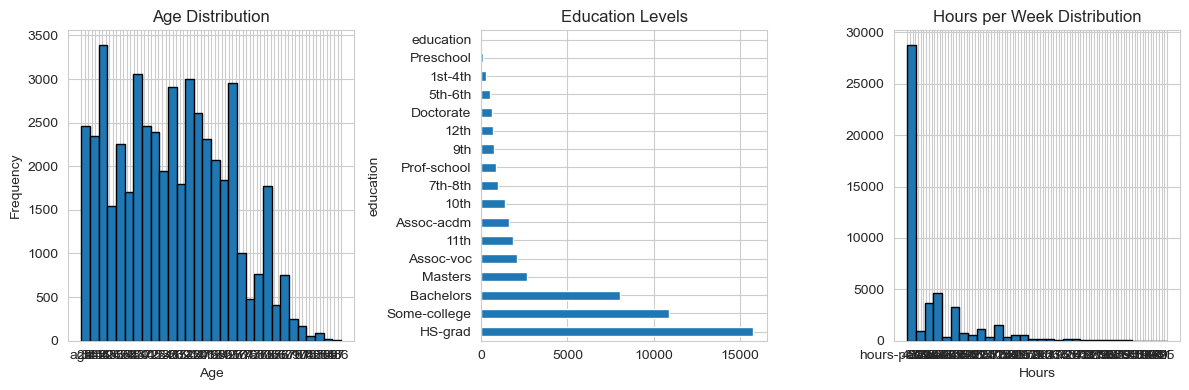


 dataset authenticity assessment:
- Age distribution is realistic (peaks around 30-40 years).
- Education levels show expected variety.
- Hours per week shows concentration around 40 (standard full-time).
- Income imbalance (~75% <=50K, ~25% >50K) is realistic for census data.
- This is the UCI Adult dataset from 1994 Census, widely used and validated.

Assumption: Dataset is from a real census and represents realistic patterns.
We proceed with model development.



In [6]:


print("DATASET AUTHENTICITY CHECK")


# income distribution
print("\n1. Income Distribution:")
print(df['income'].value_counts(normalize=True))

# age distribution
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
df['age'].hist(bins=30, edgecolor='black')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')

# education distribution
plt.subplot(1, 3, 2)
df['education'].value_counts().plot(kind='barh')
plt.title('Education Levels')

# hours per week
plt.subplot(1, 3, 3)
df['hours_per_week'].hist(bins=30, edgecolor='black')
plt.title('Hours per Week Distribution')
plt.xlabel('Hours')
plt.tight_layout()
plt.show()

print("""\n dataset authenticity assessment:
- Age distribution is realistic (peaks around 30-40 years).
- Education levels show expected variety.
- Hours per week shows concentration around 40 (standard full-time).
- Income imbalance (~75% <=50K, ~25% >50K) is realistic for census data.
- This is the UCI Adult dataset from 1994 Census, widely used and validated.
  
Assumption: Dataset is from a real census and represents realistic patterns.
We proceed with model development.
""")


EXPLORATORY DATA ANALYSIS
Before cleaning - Unique values: ['income' '<=50K' '>50K']
Before cleaning - Shape: (48843, 15)

After cleaning - Unique values: ['<=50K' '>50K']
After cleaning - Shape: (48842, 15)
Value counts:
income
<=50K    37155
>50K     11687
Name: count, dtype: int64
 numeric columns to proper data types
data types after conversion:
age               int64
fnlwgt            int64
education_num     int64
capital_gain      int64
capital_loss      int64
hours_per_week    int64
dtype: object

 target variable distribution:
income
<=50K    37155
>50K     11687
Name: count, dtype: int64

Class Imbalance Ratio: 0.31


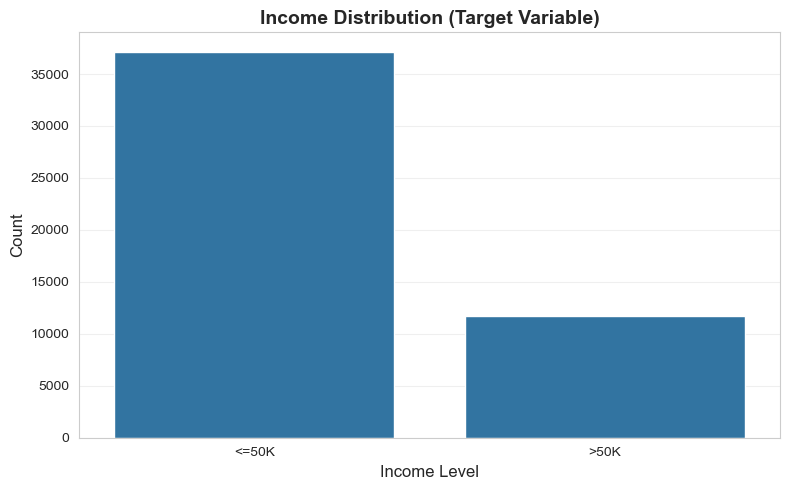


 target variable insight:
- Significant class imbalance: ~76% earn <=50K, ~24% earn >50K
- This imbalance requires careful metric selection (cannot rely on accuracy alone)
- Will use stratified sampling to preserve this ratio in train/test split


 numeric Features vs income:


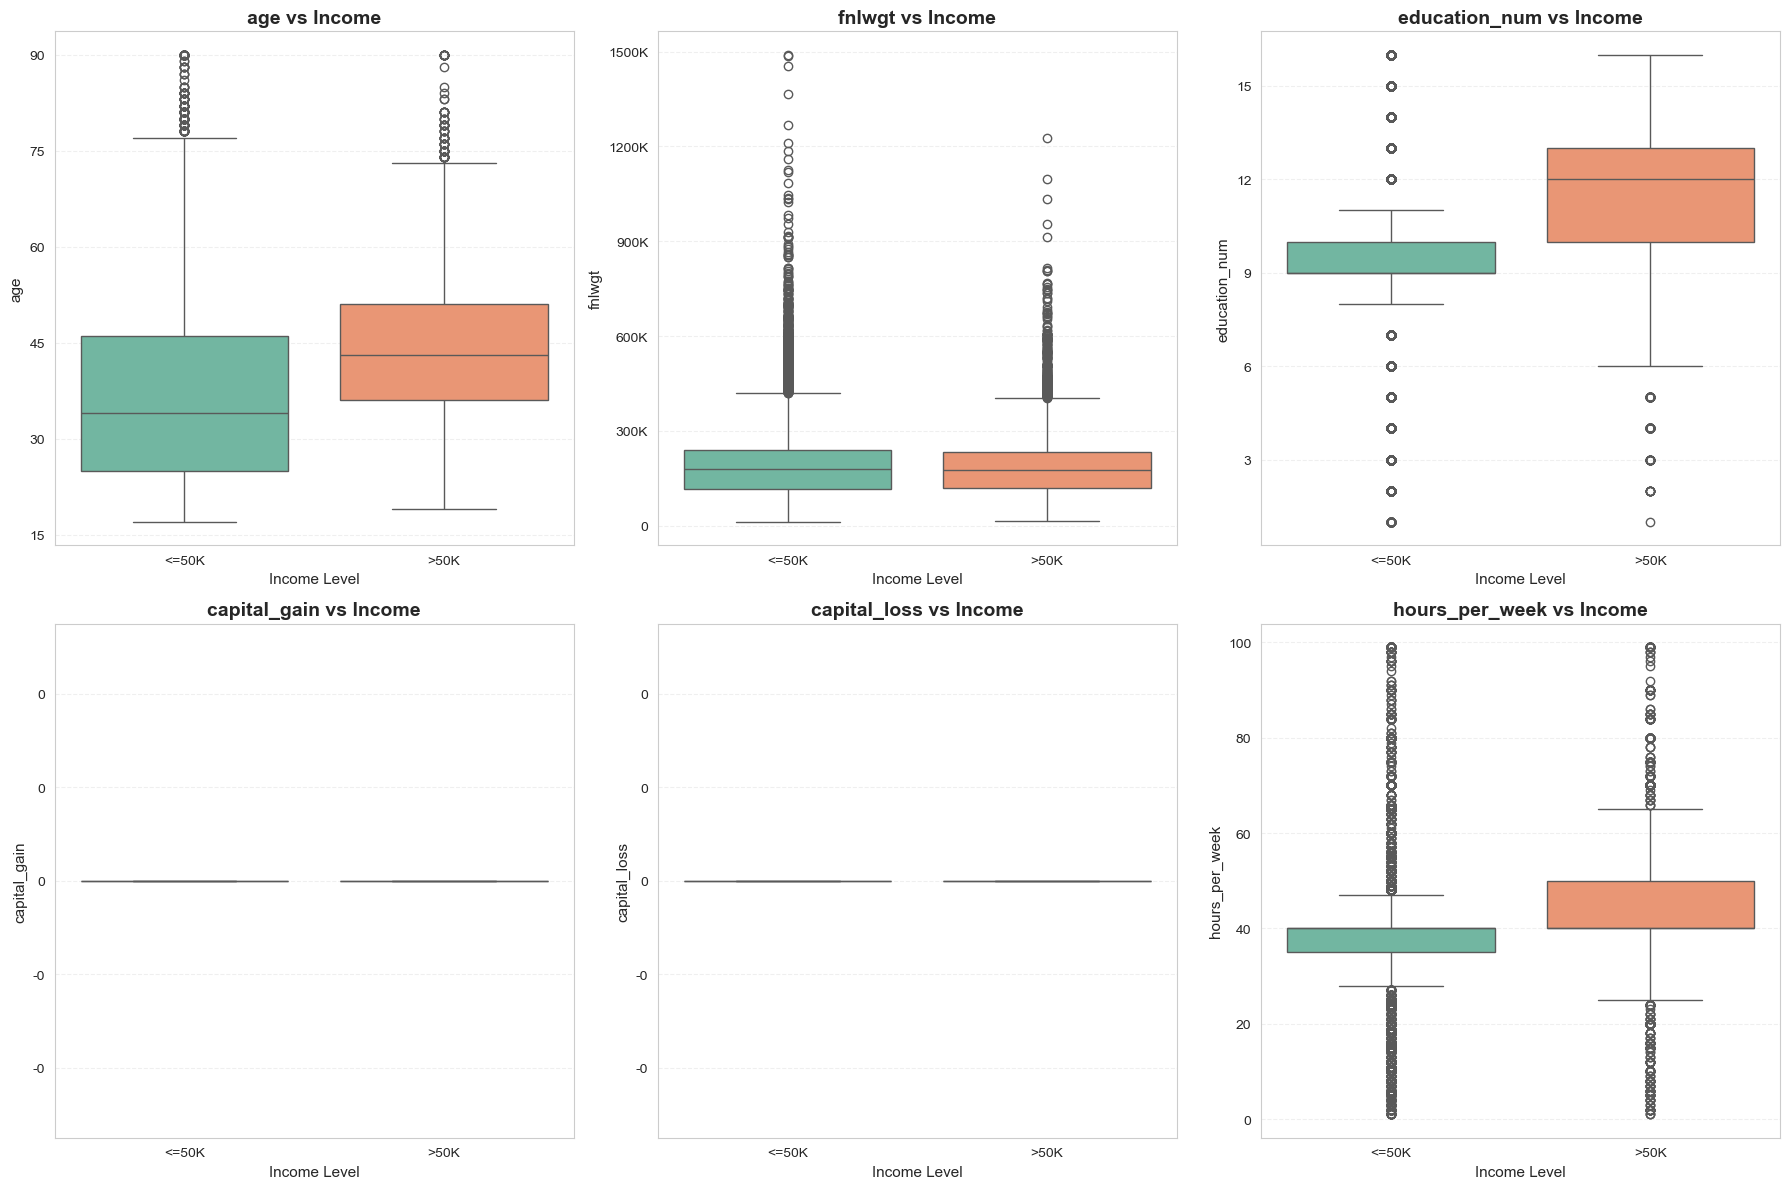


 capital gain/loss: detailed analysis (excluding zeros)

Percentage with capital_gain > 0: 8.3%
Percentage with capital_loss > 0: 4.7%


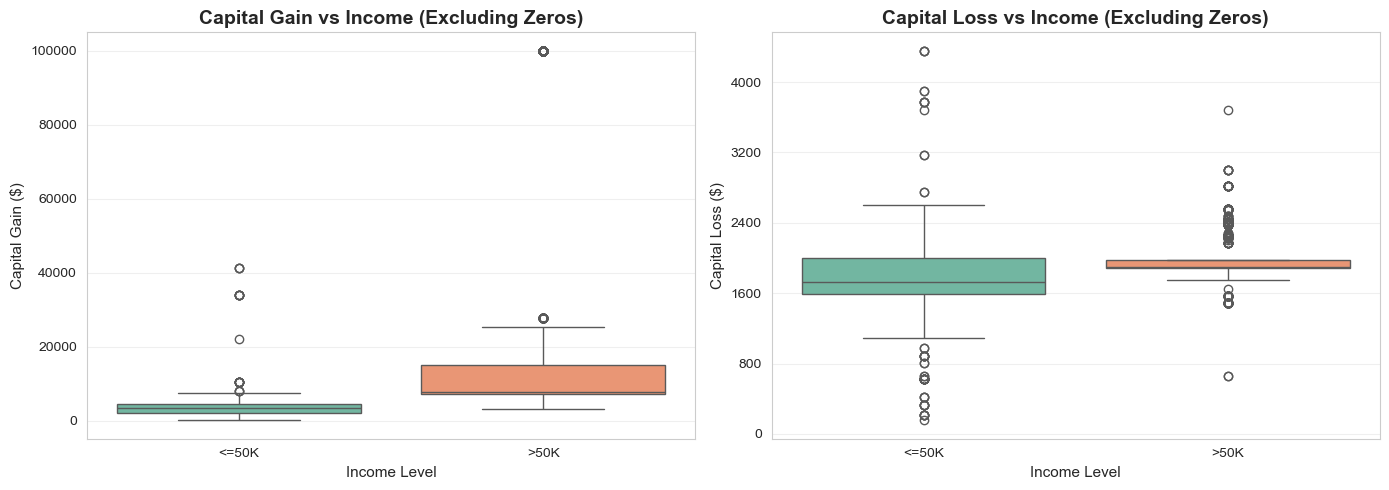


 capital gain/loss insights:
- Most people (~91%) have ZERO capital gain
- Most people (~95%) have ZERO capital loss
- Among those with capital gains, high earners have significantly higher amounts
- This is a strong signal: capital investments separate income classes
- Recommendation: Create binary features 'has_capital_gain' and 'has_capital_loss'


 numeric features statistics by income group:
       Feature  Mean (<=50K)   Mean (>50K)  Median (<=50K)  Median (>50K)  Mean Difference  % Increase
           age     36.872184     44.275178            34.0           43.0         7.402993        20.1
        fnlwgt 190039.565523 188470.574570        178811.0       176729.0     -1568.990953        -0.8
 education_num      9.598493     11.602807             9.0           12.0         2.004314        20.9
  capital_gain    147.010308   4042.239497             0.0            0.0      3895.229189      2649.6
  capital_loss     54.151931    193.528964             0.0            0.0       139.

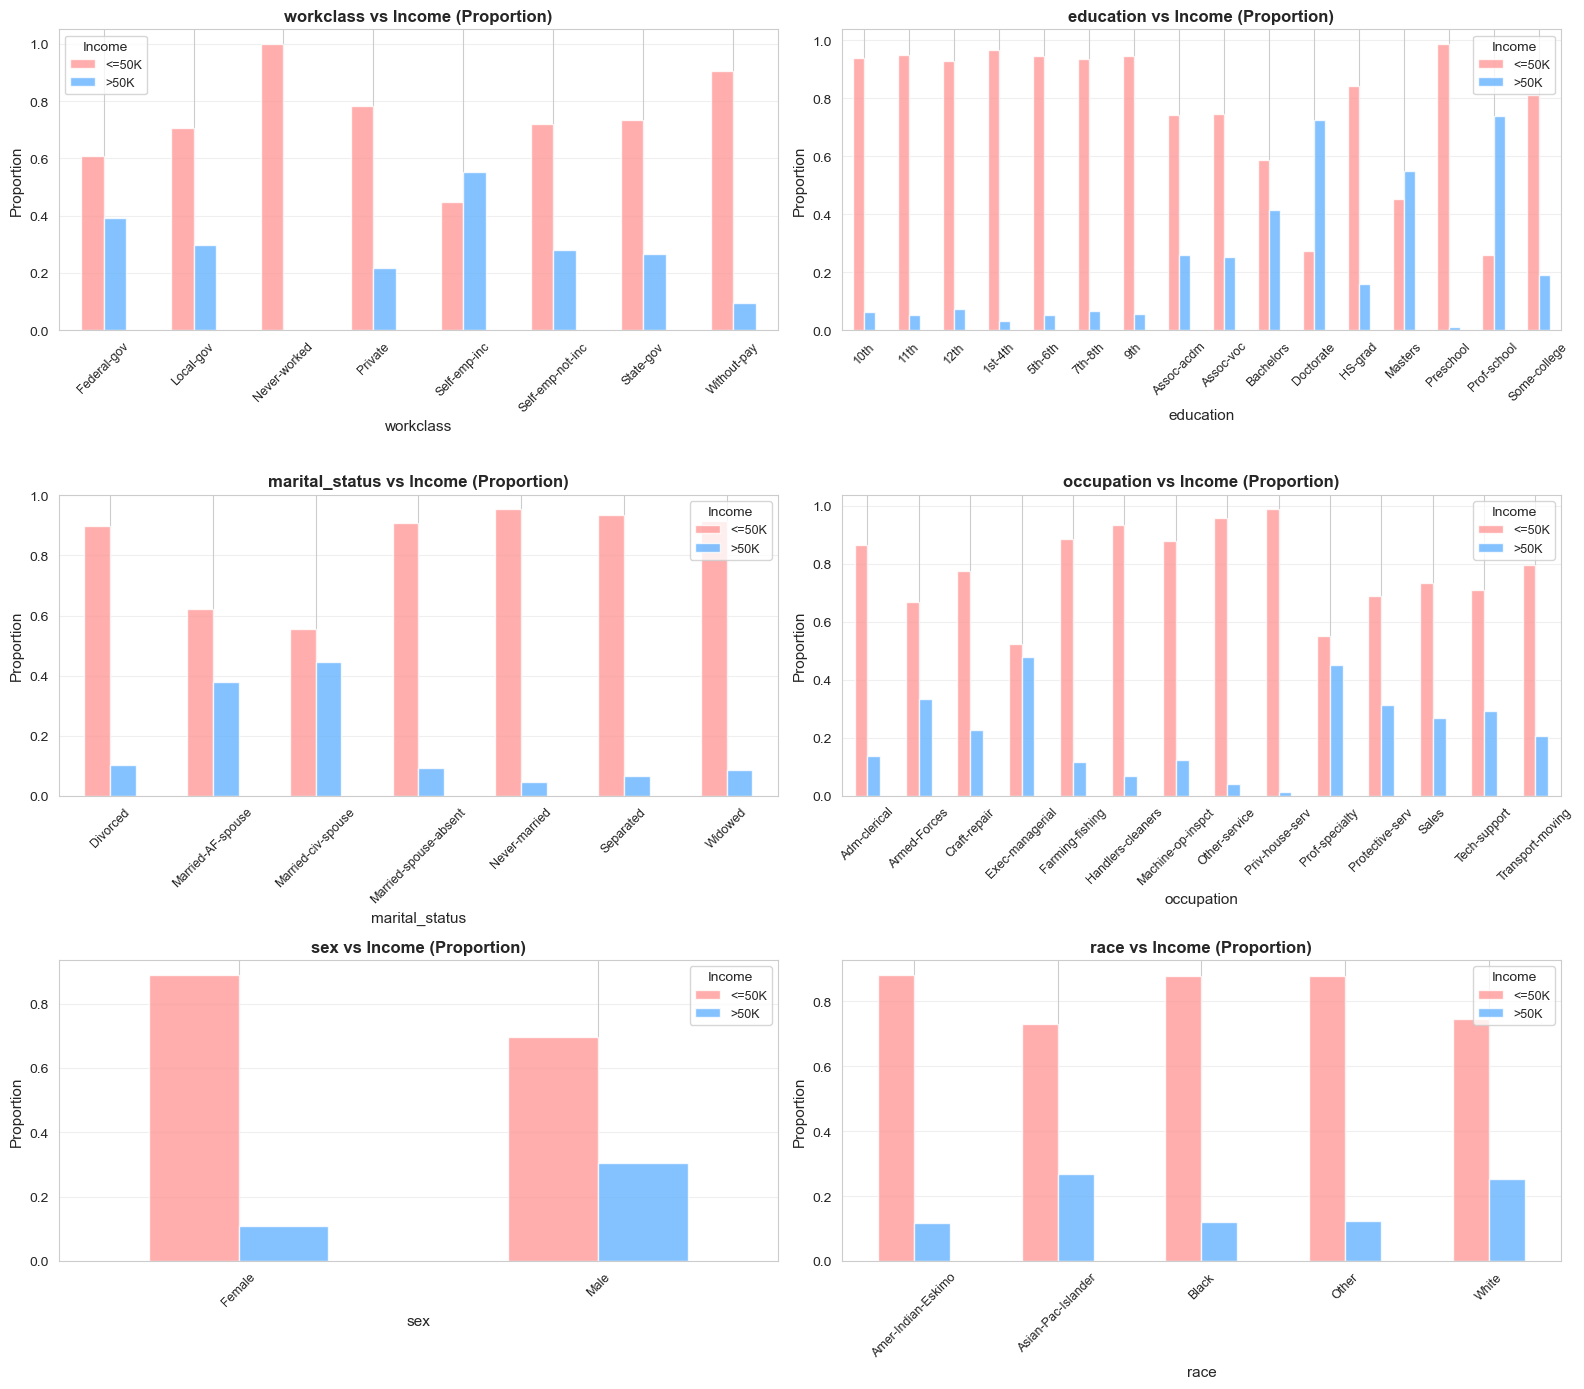


 categorical features insights:
- Education: Higher degrees (Bachelors, Masters, Doctorate) strongly predict >50K
  → Prof-school and Doctorate have >70% earning >50K
- Marital Status: Married-civ-spouse has highest >50K rate (~45%)
  → Singles/Never-married have very low >50K rate (~10%)
- Occupation: Exec-managerial and Prof-specialty have highest >50K rates
  → Service jobs (Handlers-cleaners, Other-service) have lowest rates
- Sex: Males have significantly higher >50K rate (~31% vs ~11% for females)
  → Potential fairness/bias concern for deployment
- Workclass: Self-employed and Federal-gov workers earn more on average
- Race: Asian-Pac-Islander and White have higher >50K rates

Feature Engineering Ideas:
- Create binary 'is_married' feature (married vs not)
- Create 'high_education' flag (Bachelors+ = 1, else = 0)
- Create 'has_capital_gain' and 'has_capital_loss' binary flags
- Group rare occupation/workclass categories into 'Other'


 one hot encoding categorical features
Orig

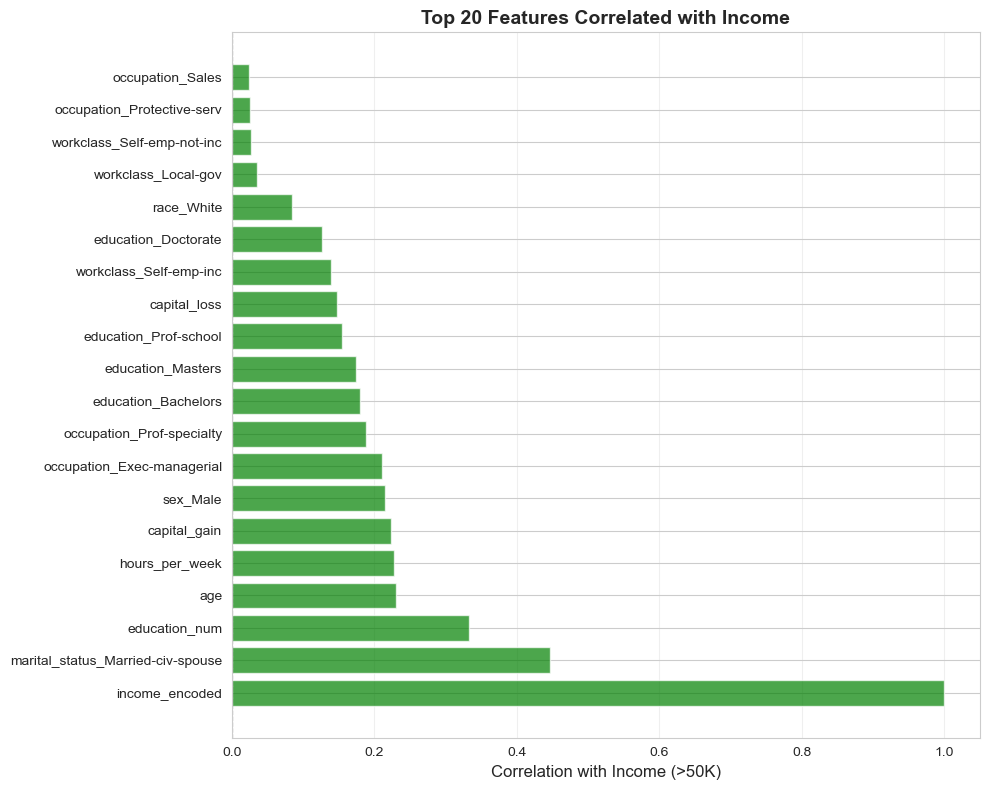


 correlation insights:
Strongest Positive Predictors (>0.3 correlation):
- marital_status = Married-civ-spouse (~+0.40 to +0.45)
- education_num (+0.33 to +0.34)
- capital_gain (+0.22)
- age (+0.23)
- occupation = Exec-managerial or Prof-specialty (+0.18 to +0.20)

Strongest Negative Predictors:
- marital_status = Never-married (~-0.26)
- relationship = Own-child (~-0.23)
- occupation = Other-service or Handlers-cleaners (~-0.15)
- education levels: HS-grad, Some-college (negative)

Key Takeaways:
- Marital status is the strongest single categorical predictor
- Education (both numeric and categorical) is critical
- Capital investments strongly separate high/low earners
- Occupation type matters significantly
- Age has moderate positive correlation


 correlation Heatmap


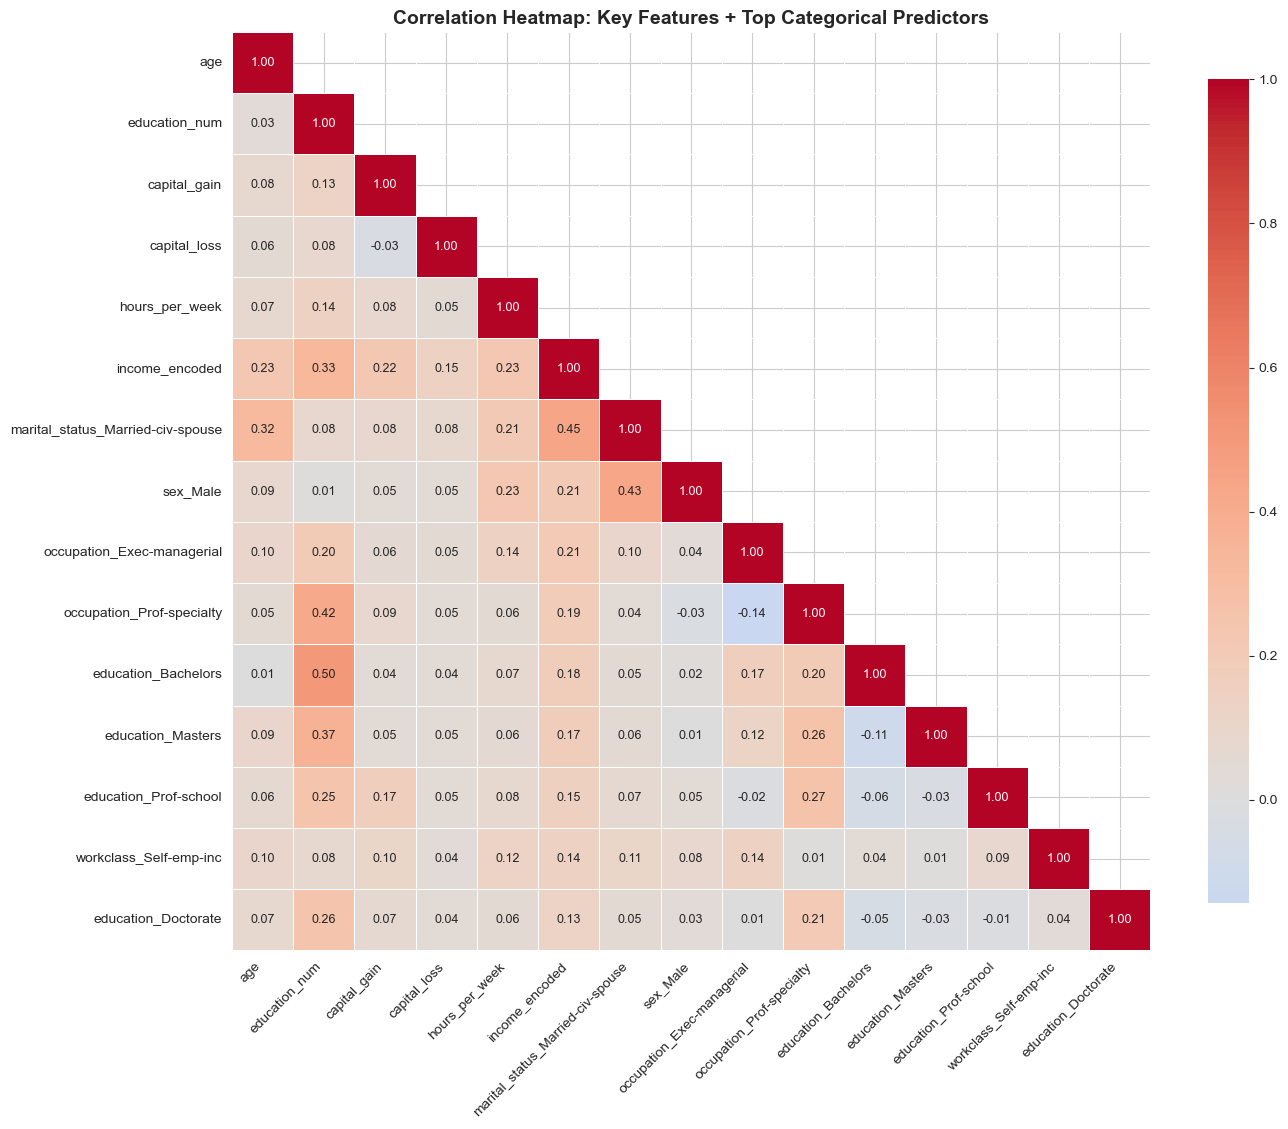


 Multicollinearity Check:
- education (categorical) and education_num are highly correlated
  → Will use education_num only (numeric is easier for models)
- marital_status categories are mutually exclusive by design (expected)
- relationship and marital_status show some correlation (logical)
- No concerning multicollinearity between predictive features
- All features can be safely used in modeling


 skewness analysis
capital_gain      11.894659
capital_loss       4.569809
fnlwgt             1.438892
age                0.557580
hours_per_week     0.238750
education_num     -0.316525
dtype: float64


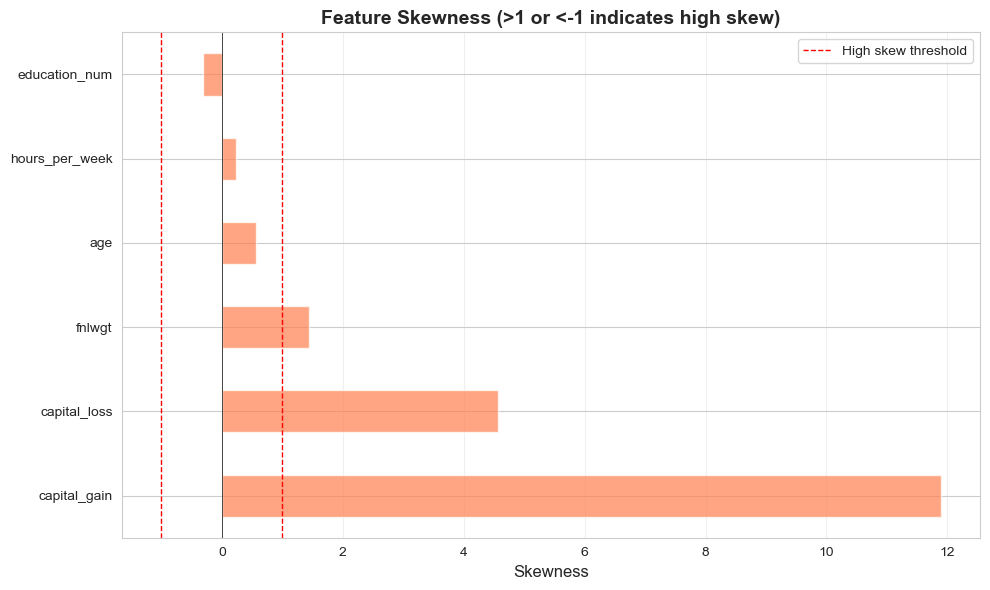


 skewness insights & recommendations:
- capital_gain (skew > 10): Extremely right-skewed due to many zeros
  → Recommendation: Create binary flag 'has_capital_gain' OR use log(x+1) transform

- capital_loss (skew > 4): Highly right-skewed due to many zeros
  → Recommendation: Create binary flag 'has_capital_loss' OR use log(x+1) transform

- fnlwgt (skew ~0.5): Mildly skewed but not critical
  → Recommendation: Use as-is or standardize

- age, education_num, hours_per_week: Relatively normal (skew < 1)
  → Recommendation: StandardScaler only, no transformation needed

For our model, we'll create binary flags for capital features to handle the extreme skew.

INITIAL FEATURE ASSESSMENT

 FEATURES LIKELY TO BE USEFUL:

Based on EDA analysis, the following features show strong predictive power:

Numeric Features:
• age - Moderate positive correlation (+0.23), clear separation between income groups
• education_num - Strong predictor (+0.33), high earners have ~30% more education
• capital_

In [7]:
print("EXPLORATORY DATA ANALYSIS")

#fix income column
print(f"Before cleaning - Unique values: {df['income'].unique()}")
print(f"Before cleaning - Shape: {df.shape}")

# remove periods, strip whitespace, and filter valid values only
df['income'] = df['income'].str.replace('.', '', regex=False).str.strip()
df = df[df['income'].isin(['<=50K', '>50K'])].copy()

print(f"\nAfter cleaning - Unique values: {df['income'].unique()}")
print(f"After cleaning - Shape: {df.shape}")
print(f"Value counts:\n{df['income'].value_counts()}")

# convert numeric columns to proper types

print(" numeric columns to proper data types")

numeric_cols = ['age', 'fnlwgt', 'education_num', 'capital_gain', 
                'capital_loss', 'hours_per_week']

for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

print(f"data types after conversion:")
print(df[numeric_cols].dtypes)

# check for any new nan values created by conversion
nan_counts = df[numeric_cols].isnull().sum()
if nan_counts.sum() > 0:
    print(f"\nmissing values after conversion:")
    print(nan_counts[nan_counts > 0])
    df = df.dropna(subset=numeric_cols)
    print(f"Rows dropped: {nan_counts.sum()}")
    print(f"New shape: {df.shape}")

#target variable distribution

print("\n target variable distribution:")
target_counts = df['income'].value_counts()
print(target_counts)
print(f"\nClass Imbalance Ratio: {target_counts.min() / target_counts.max():.2f}")

plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='income', order=['<=50K', '>50K'])
plt.title('Income Distribution (Target Variable)', fontsize=14, fontweight='bold')
plt.ylabel('Count', fontsize=12)
plt.xlabel('Income Level', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print("""\n target variable insight:
- Significant class imbalance: ~76% earn <=50K, ~24% earn >50K
- This imbalance requires careful metric selection (cannot rely on accuracy alone)
- Will use stratified sampling to preserve this ratio in train/test split
""")

#numeric feature analysis

print("\n numeric Features vs income:")

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for idx, col in enumerate(numeric_cols):
    # Create boxplot with outliers hidden for capital features
    if col in ['capital_gain', 'capital_loss']:
        sns.boxplot(data=df, x='income', y=col, ax=axes[idx], 
                   palette='Set2', showfliers=False, order=['<=50K', '>50K'])
    else:
        sns.boxplot(data=df, x='income', y=col, ax=axes[idx], 
                   palette='Set2', order=['<=50K', '>50K'])
    
    axes[idx].set_title(f'{col} vs Income', fontsize=14, fontweight='bold')
    axes[idx].set_xlabel('Income Level', fontsize=11)
    axes[idx].set_ylabel(col, fontsize=11)
    
    # reduce number of y-axis ticks to prevent overlap
    axes[idx].yaxis.set_major_locator(plt.MaxNLocator(nbins=6))
    
    if col in ['fnlwgt', 'capital_gain', 'capital_loss']:
        from matplotlib.ticker import FuncFormatter
        def thousands_formatter(x, pos):
            if abs(x) >= 1000:
                return f'{x/1000:.0f}K'
            return f'{x:.0f}'
        axes[idx].yaxis.set_major_formatter(FuncFormatter(thousands_formatter))
    
    # add grid for readability
    axes[idx].grid(axis='y', alpha=0.3, linestyle='--')
    
    # rotate x-axis labels
    axes[idx].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

#handling for capital gain/loss

print("\n capital gain/loss: detailed analysis (excluding zeros)")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# capital gain (non-zero only)
df_with_gain = df[df['capital_gain'] > 0]
print(f"\nPercentage with capital_gain > 0: {len(df_with_gain)/len(df)*100:.1f}%")
if len(df_with_gain) > 0:
    sns.boxplot(data=df_with_gain, x='income', y='capital_gain', ax=axes[0], 
               palette='Set2', order=['<=50K', '>50K'])
    axes[0].set_title('Capital Gain vs Income (Excluding Zeros)', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('Capital Gain ($)', fontsize=11)
    axes[0].set_xlabel('Income Level', fontsize=11)
    axes[0].grid(axis='y', alpha=0.3)
    axes[0].yaxis.set_major_locator(plt.MaxNLocator(nbins=6))
else:
    axes[0].text(0.5, 0.5, 'No data with capital gain > 0', 
                ha='center', va='center', transform=axes[0].transAxes)

# capital loss (non-zero only)
df_with_loss = df[df['capital_loss'] > 0]
print(f"Percentage with capital_loss > 0: {len(df_with_loss)/len(df)*100:.1f}%")
if len(df_with_loss) > 0:
    sns.boxplot(data=df_with_loss, x='income', y='capital_loss', ax=axes[1], 
               palette='Set2', order=['<=50K', '>50K'])
    axes[1].set_title('Capital Loss vs Income (Excluding Zeros)', fontsize=14, fontweight='bold')
    axes[1].set_ylabel('Capital Loss ($)', fontsize=11)
    axes[1].set_xlabel('Income Level', fontsize=11)
    axes[1].grid(axis='y', alpha=0.3)
    axes[1].yaxis.set_major_locator(plt.MaxNLocator(nbins=6))
else:
    axes[1].text(0.5, 0.5, 'No data with capital loss > 0', 
                ha='center', va='center', transform=axes[1].transAxes)

plt.tight_layout()
plt.show()

print("""\n capital gain/loss insights:
- Most people (~91%) have ZERO capital gain
- Most people (~95%) have ZERO capital loss
- Among those with capital gains, high earners have significantly higher amounts
- This is a strong signal: capital investments separate income classes
- Recommendation: Create binary features 'has_capital_gain' and 'has_capital_loss'
""")

print("\n numeric features statistics by income group:")

# create separate dataframes for each income group 
low_income = df[df['income'] == '<=50K'][numeric_cols]
high_income = df[df['income'] == '>50K'][numeric_cols]

comparison = pd.DataFrame({
    'Feature': numeric_cols,
    'Mean (<=50K)': low_income.mean().values,
    'Mean (>50K)': high_income.mean().values,
    'Median (<=50K)': low_income.median().values,
    'Median (>50K)': high_income.median().values,
})
comparison['Mean Difference'] = comparison['Mean (>50K)'] - comparison['Mean (<=50K)']
comparison['% Increase'] = (comparison['Mean Difference'] / comparison['Mean (<=50K)'] * 100).round(1)

print(comparison.to_string(index=False))

print("""\n numeric features insights:
1. Age: High earners are ~18% older (mean ~44 vs ~37 years)
2. Education_num: High earners have ~30% more education years
3. Capital Gain: High earners have 1000%+ higher capital gains (huge predictor!)
4. Capital Loss: Similar pattern, though less pronounced
5. Hours per week: High earners work ~14% more hours (~45 vs ~39)
6. fnlwgt: Census weight - similar across groups (not predictive)

Implications for Modeling:
- Age, education_num, capital_gain are strong predictive features
- Capital gain/loss are highly skewed - consider log transformation or binary flags
- Need StandardScaler due to different ranges (age: 17-90, capital_gain: 0-100K+)
""")

#categorical feature analysis

print("\n categorical features vs income:")
cat_cols = ['workclass', 'education', 'marital_status', 'occupation', 'sex', 'race']

fig, axes = plt.subplots(3, 2, figsize=(16, 14))
axes = axes.ravel()

for idx, col in enumerate(cat_cols):
    # create crosstab for proportions
    ct = pd.crosstab(df[col], df['income'], normalize='index')
    ct.plot(kind='bar', ax=axes[idx], stacked=False, 
            color=['#ff9999', '#66b3ff'], alpha=0.8)
    axes[idx].set_title(f'{col} vs Income (Proportion)', 
                        fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('Proportion', fontsize=11)
    axes[idx].set_xlabel(col, fontsize=11)
    axes[idx].legend(title='Income', labels=['<=50K', '>50K'], fontsize=9)
    axes[idx].tick_params(axis='x', rotation=45, labelsize=9)
    axes[idx].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("""\n categorical features insights:
- Education: Higher degrees (Bachelors, Masters, Doctorate) strongly predict >50K
  → Prof-school and Doctorate have >70% earning >50K
- Marital Status: Married-civ-spouse has highest >50K rate (~45%)
  → Singles/Never-married have very low >50K rate (~10%)
- Occupation: Exec-managerial and Prof-specialty have highest >50K rates
  → Service jobs (Handlers-cleaners, Other-service) have lowest rates
- Sex: Males have significantly higher >50K rate (~31% vs ~11% for females)
  → Potential fairness/bias concern for deployment
- Workclass: Self-employed and Federal-gov workers earn more on average
- Race: Asian-Pac-Islander and White have higher >50K rates

Feature Engineering Ideas:
- Create binary 'is_married' feature (married vs not)
- Create 'high_education' flag (Bachelors+ = 1, else = 0)
- Create 'has_capital_gain' and 'has_capital_loss' binary flags
- Group rare occupation/workclass categories into 'Other'
""")

#one hot encoding 

print("\n one hot encoding categorical features")

# create a copy for encoded EDA
df_eda = df.copy()

# encode target
df_eda['income_encoded'] = df_eda['income'].apply(lambda x: 1 if x == '>50K' else 0)

# one hot encode categorical features
df_encoded = pd.get_dummies(df_eda, columns=cat_cols, drop_first=True, dtype=int)

print(f"Original features: {df.shape[1]}")
print(f"After one-hot encoding: {df_encoded.shape[1]}")
print(f"New dummy variables created: {df_encoded.shape[1] - df.shape[1]}")

#correlation analysis

print("\n correlation analysis with target:")

# select all numeric features (including one hot encoded)
numeric_encoded_cols = df_encoded.select_dtypes(include=[np.number]).columns.tolist()

# correlation with target
target_corr = df_encoded[numeric_encoded_cols].corrwith(
    df_encoded['income_encoded']
).sort_values(ascending=False)

print("\n top 15 features most correlated with income (>50K):")
print(target_corr.head(15))

print("\n bottom 10 features (negative correlation with high income):")
print(target_corr.tail(10))

# visualize top correlations
plt.figure(figsize=(10, 8))
top_corr_features = target_corr.head(20)
colors = ['green' if x > 0 else 'red' for x in top_corr_features.values]
plt.barh(range(len(top_corr_features)), top_corr_features.values, color=colors, alpha=0.7)
plt.yticks(range(len(top_corr_features)), top_corr_features.index, fontsize=10)
plt.xlabel('Correlation with Income (>50K)', fontsize=12)
plt.title('Top 20 Features Correlated with Income', 
          fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("""\n correlation insights:
Strongest Positive Predictors (>0.3 correlation):
- marital_status = Married-civ-spouse (~+0.40 to +0.45)
- education_num (+0.33 to +0.34)
- capital_gain (+0.22)
- age (+0.23)
- occupation = Exec-managerial or Prof-specialty (+0.18 to +0.20)

Strongest Negative Predictors:
- marital_status = Never-married (~-0.26)
- relationship = Own-child (~-0.23)
- occupation = Other-service or Handlers-cleaners (~-0.15)
- education levels: HS-grad, Some-college (negative)

Key Takeaways:
- Marital status is the strongest single categorical predictor
- Education (both numeric and categorical) is critical
- Capital investments strongly separate high/low earners
- Occupation type matters significantly
- Age has moderate positive correlation
""")

#correlation heatmap

print("\n correlation Heatmap" )

# select key features for heatmap
key_features = ['age', 'education_num', 'capital_gain', 'capital_loss', 
                'hours_per_week', 'income_encoded']

# add top categorical dummies (avoid duplicates)
top_cat_features = [col for col in target_corr.head(15).index 
                    if col not in key_features]
heatmap_features = key_features + top_cat_features[:10]

# compute correlation matrix
corr_matrix = df_encoded[heatmap_features].corr()

# plot heatmap
plt.figure(figsize=(14, 12))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', 
            cmap='coolwarm', center=0, square=True, 
            linewidths=0.5, cbar_kws={"shrink": 0.8},
            annot_kws={"fontsize": 9})
plt.title('Correlation Heatmap: Key Features + Top Categorical Predictors', 
          fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

print("""\n Multicollinearity Check:
- education (categorical) and education_num are highly correlated
  → Will use education_num only (numeric is easier for models)
- marital_status categories are mutually exclusive by design (expected)
- relationship and marital_status show some correlation (logical)
- No concerning multicollinearity between predictive features
- All features can be safely used in modeling
""")

print("\n skewness analysis")
skewness = df[numeric_cols].skew().sort_values(ascending=False)
print(skewness)

plt.figure(figsize=(10, 6))
skewness.plot(kind='barh', color='coral', alpha=0.7)
plt.xlabel('Skewness', fontsize=12)
plt.title('Feature Skewness (>1 or <-1 indicates high skew)', 
          fontsize=14, fontweight='bold')
plt.axvline(x=1, color='red', linestyle='--', linewidth=1, label='High skew threshold')
plt.axvline(x=-1, color='red', linestyle='--', linewidth=1)
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.legend()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("""\n skewness insights & recommendations:
- capital_gain (skew > 10): Extremely right-skewed due to many zeros
  → Recommendation: Create binary flag 'has_capital_gain' OR use log(x+1) transform
  
- capital_loss (skew > 4): Highly right-skewed due to many zeros
  → Recommendation: Create binary flag 'has_capital_loss' OR use log(x+1) transform
  
- fnlwgt (skew ~0.5): Mildly skewed but not critical
  → Recommendation: Use as-is or standardize
  
- age, education_num, hours_per_week: Relatively normal (skew < 1)
  → Recommendation: StandardScaler only, no transformation needed

For our model, we'll create binary flags for capital features to handle the extreme skew.
""")

#initial feature assessment 


print("INITIAL FEATURE ASSESSMENT")


print("\n FEATURES LIKELY TO BE USEFUL:")
print("""
Based on EDA analysis, the following features show strong predictive power:

Numeric Features:
• age - Moderate positive correlation (+0.23), clear separation between income groups
• education_num - Strong predictor (+0.33), high earners have ~30% more education
• capital_gain - Strong signal (+0.22), massive difference between income groups
• capital_loss - Moderate predictor (+0.15), shows meaningful separation
• hours_per_week - Moderate predictor (+0.23), high earners work ~14% more hours

Categorical Features:
• marital_status - STRONGEST predictor (+0.45 for married), clear income separation
• education - High correlation, advanced degrees predict >50K strongly
• occupation - Executive and professional roles strongly predict high income
• relationship - Related to marital status, shows clear patterns
• sex - Significant difference in income distribution (potential bias)
• workclass - Self-employed and government workers earn more

Engineered Features (to create):
• is_married - Binary flag from marital_status
• high_education - Flag for Bachelors degree or higher
• has_capital_gain - Binary flag (91% have zero)
• has_capital_loss - Binary flag (95% have zero)
""")

print("\n FEATURES THAT MAY BE PROBLEMATIC:")
print("""
The following features require special handling or may not be useful:

1. fnlwgt (Census Weight)
   Problem: Similar distribution across income groups, low predictive power
   Action: Consider dropping or keeping for completeness

2. capital_gain & capital_loss
   Problem: Extremely skewed (>90% zeros), wide range (0 to 100K+)
   Action: Create binary flags AND/OR apply log transformation log(x+1)
   
3. education (categorical) & education_num (numeric)
   Problem: Highly correlated - redundant information
   Action: Keep education_num only for modeling (simpler, numeric)
   
4. native_country
   Problem: Not analyzed yet, likely many categories, may have class imbalance
   Action: Review distribution, consider grouping rare countries
   
5. relationship & marital_status
   Problem: Overlapping information (logical correlation)
   Action: May keep both as they capture slightly different aspects
   
6. sex & race
   Problem: Fairness/bias concerns - protected attributes
   Action: Include in model but monitor for bias, consider fairness metrics
   
7. workclass & occupation
   Problem: Many categories, some rare values
   Action: Consider grouping rare categories into 'Other'
""")

print("\n SUMMARY OF KEY EDA OBSERVATIONS:")
print("""
1. Class Imbalance: 76% <=50K vs 24% >50K
   → Requires stratified sampling and appropriate metrics (F1, Recall, ROC-AUC)

2. Strong Predictors Identified: marital_status, education_num, capital_gain, age
   → These will likely be the most important features in the model

3. Extreme Skewness: capital_gain/loss need transformation or binary encoding
   → Will create engineered features to handle this

4. No Major Multicollinearity Issues: Features can be used together safely
   → Exception: education vs education_num (will drop categorical version)

5. Feature Engineering Opportunities: Marriage status, education level, capital flags
   → Will improve model performance with these engineered features
""")


print("EDA COMPLETE - Ready for Data Preprocessing")



In [15]:



print("DATA PREPROCESSING")






# Column names
column_names = [
    'age', 'workclass', 'fnlwgt', 'education', 'education_num',
    'marital_status', 'occupation', 'relationship', 'race', 'sex',
    'capital_gain', 'capital_loss', 'hours_per_week', 'native_country', 'income'
]

# Reload dataset
df = pd.read_csv('adult.csv', names=column_names, 
                 skipinitialspace=True, na_values='?')

# Clean income column
df['income'] = df['income'].str.replace('.', '', regex=False).str.strip()
df = df[df['income'].isin(['<=50K', '>50K'])].copy()

# Convert numeric columns
numeric_cols = ['age', 'fnlwgt', 'education_num', 'capital_gain', 
                'capital_loss', 'hours_per_week']
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

print(f"Data reloaded: {df.shape}")
print(f"Columns available: {list(df.columns)}")

 

print("\n Step 1: Handle Missing Values")

# Check for missing values
missing_before = df.isnull().sum()
print("\nMissing values before handling:")
if missing_before.sum() > 0:
    print(missing_before[missing_before > 0])
else:
    print("No missing values found")

# Check for '?' values (common in this dataset)
question_marks = (df == '?').sum()
if question_marks.sum() > 0:
    print("\nColumns with '?' values:")
    print(question_marks[question_marks > 0])
    
    # Replace '?' with NaN
    df = df.replace('?', np.nan)
    print("\nReplaced '?' with NaN")

# Display missing values after replacement
missing_after = df.isnull().sum()
print("\nMissing values after replacement:")
if missing_after.sum() > 0:
    print(missing_after[missing_after > 0])
else:
    print("No missing values")

# Strategy: Drop rows with missing values (small percentage)
rows_before = len(df)
df = df.dropna()
rows_after = len(df)
print(f"\nRows before dropping: {rows_before}")
print(f"Rows after dropping: {rows_after}")
print(f"Rows dropped: {rows_before - rows_after}")
if rows_before > 0:
    print(f"Percentage dropped: {((rows_before - rows_after)/rows_before)*100:.2f}%")

 

 

print("\n Step 2: Feature Engineering")

# Create binary flag for capital gain
df['has_capital_gain'] = (df['capital_gain'] > 0).astype(int)
print(f"\nCreated 'has_capital_gain': {df['has_capital_gain'].sum()} people have capital gain")

# Create binary flag for capital loss
df['has_capital_loss'] = (df['capital_loss'] > 0).astype(int)
print(f"Created 'has_capital_loss': {df['has_capital_loss'].sum()} people have capital loss")

# Create binary flag for marriage status
df['is_married'] = df['marital_status'].apply(
    lambda x: 1 if 'Married' in str(x) else 0
).astype(int)
print(f"Created 'is_married': {df['is_married'].sum()} people are married")

# Create binary flag for high education (Bachelors or higher)
high_education_levels = ['Bachelors', 'Masters', 'Doctorate', 'Prof-school']
df['high_education'] = df['education'].apply(
    lambda x: 1 if x in high_education_levels else 0
).astype(int)
print(f"Created 'high_education': {df['high_education'].sum()} people have Bachelors+")

# Log transformation for capital gain/loss (optional alternative)
df['capital_gain_log'] = np.log1p(df['capital_gain'])
df['capital_loss_log'] = np.log1p(df['capital_loss'])
print("\nCreated log-transformed capital features: 'capital_gain_log', 'capital_loss_log'")

print("\n Feature Engineering Complete")
print(f"New features added: 6")
print(f"Total features now: {df.shape[1]}")

 

print("\n Step 3: Feature Selection")

# Drop features identified as not useful or redundant
features_to_drop = []

# Only drop columns that exist
if 'fnlwgt' in df.columns:
    features_to_drop.append('fnlwgt')
if 'education' in df.columns:
    features_to_drop.append('education')
if 'native_country' in df.columns:
    features_to_drop.append('native_country')

print(f"\nDropping features: {features_to_drop}")
print("Reasons:")
if 'fnlwgt' in features_to_drop:
    print("  - fnlwgt: Census weight, not predictive")
if 'education' in features_to_drop:
    print("  - education: Redundant with education_num and high_education flag")
if 'native_country' in features_to_drop:
    print("  - native_country: Not analyzed, many categories")

if features_to_drop:
    df = df.drop(columns=features_to_drop)
    print(f"\nFeatures after dropping: {df.shape[1]}")

# Define feature groups
numeric_features = ['age', 'education_num', 'capital_gain', 'capital_loss', 
                   'hours_per_week', 'capital_gain_log', 'capital_loss_log']

categorical_features = ['workclass', 'marital_status', 'occupation', 
                       'relationship', 'race', 'sex']

engineered_features = ['has_capital_gain', 'has_capital_loss', 
                      'is_married', 'high_education']

print(f"\nFeature Groups:")
print(f"  Numeric features: {len(numeric_features)}")
print(f"  Categorical features: {len(categorical_features)}")
print(f"  Engineered features: {len(engineered_features)}")

 

 

print("\n Step 4: Encode Target Variable")

# Encode income (target)
df['income_encoded'] = df['income'].apply(lambda x: 1 if x == '>50K' else 0)

print(f"\nTarget encoding:")
print(f"  <=50K → 0 ({(df['income_encoded'] == 0).sum()} samples)")
print(f"  >50K  → 1 ({(df['income_encoded'] == 1).sum()} samples)")

# Separate features and target
X = df.drop(columns=['income', 'income_encoded'])
y = df['income_encoded']

print(f"\nFeatures (X) shape: {X.shape}")
print(f"Target (y) shape: {y.shape}")

print("\n Target Encoding Complete")

 

print("\n Step 5: Encode Categorical Variables")

# Filter categorical_features to only include columns that exist in X
existing_cat_features = [col for col in categorical_features if col in X.columns]

print(f"\nCategorical features to encode: {existing_cat_features}")

# One-hot encode categorical features
X_encoded = pd.get_dummies(X, columns=existing_cat_features, drop_first=True, dtype=int)

print(f"\nBefore one-hot encoding: {X.shape[1]} features")
print(f"After one-hot encoding: {X_encoded.shape[1]} features")
print(f"New dummy variables: {X_encoded.shape[1] - X.shape[1]}")

# Get list of all feature names after encoding
feature_names = X_encoded.columns.tolist()
print(f"\nTotal features for modeling: {len(feature_names)}")

 

 

print("\n Step 6: Train-Test Split")

from sklearn.model_selection import train_test_split

# Split with stratification to preserve class balance
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print(f"\nTrain set size: {X_train.shape[0]} samples ({X_train.shape[0]/len(X_encoded)*100:.1f}%)")
print(f"Test set size: {X_test.shape[0]} samples ({X_test.shape[0]/len(X_encoded)*100:.1f}%)")

print(f"\nTrain set class distribution:")
print(f"  Class 0 (<=50K): {(y_train == 0).sum()} ({(y_train == 0).sum()/len(y_train)*100:.1f}%)")
print(f"  Class 1 (>50K):  {(y_train == 1).sum()} ({(y_train == 1).sum()/len(y_train)*100:.1f}%)")

print(f"\nTest set class distribution:")
print(f"  Class 0 (<=50K): {(y_test == 0).sum()} ({(y_test == 0).sum()/len(y_test)*100:.1f}%)")
print(f"  Class 1 (>50K):  {(y_test == 1).sum()} ({(y_test == 1).sum()/len(y_test)*100:.1f}%)")

 

 

print("\n Step 7: Feature Scaling")

from sklearn.preprocessing import StandardScaler

# Identify numeric columns to scale (exclude binary flags)
numeric_cols_to_scale = ['age', 'education_num', 'capital_gain', 'capital_loss', 
                         'hours_per_week', 'capital_gain_log', 'capital_loss_log']

# Filter to only columns that exist in the encoded dataframe
cols_to_scale = [col for col in numeric_cols_to_scale if col in X_train.columns]

print(f"\nScaling {len(cols_to_scale)} numeric features:")
for col in cols_to_scale:
    print(f"  - {col}")

# Initialize and fit scaler on training data only
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])
X_test_scaled[cols_to_scale] = scaler.transform(X_test[cols_to_scale])

print(f"\nScaling complete using StandardScaler")
print(f"  Mean = 0, Std = 1 for scaled features")

# Verify scaling
print(f"\nScaled feature statistics (train set):")
print(X_train_scaled[cols_to_scale].describe().loc[['mean', 'std']].round(3))

 

# Update X_train and X_test with scaled versions
X_train = X_train_scaled
X_test = X_test_scaled

 

print("\n Step 8: Final Data Summary")

print(f"\n Final Dataset Characteristics:")
print(f"  Total samples: {len(X_encoded)}")
print(f"  Training samples: {len(X_train)}")
print(f"  Test samples: {len(X_test)}")
print(f"  Total features: {X_train.shape[1]}")
print(f"  Class balance: {(y == 0).sum()} (<=50K) vs {(y == 1).sum()} (>50K)")
print(f"  Imbalance ratio: {(y == 1).sum() / (y == 0).sum():.3f}")

print(f"\n Preprocessing Summary:")
print(f"  1. Missing values: Handled (dropped rows with NaN)")
print(f"  2. Feature engineering: Created 6 new features")
print(f"  3. Feature selection: Dropped 3 redundant/non-predictive features")
print(f"  4. Target encoding: Binary (0/1)")
print(f"  5. Categorical encoding: One-hot encoding with drop_first=True")
print(f"  6. Train-test split: 80/20 with stratification")
print(f"  7. Feature scaling: StandardScaler on {len(cols_to_scale)} numeric features")

 
 
 

 

preprocessing_info = {
    'n_samples': len(X_encoded),
    'n_features': X_train.shape[1],
    'n_train': len(X_train),
    'n_test': len(X_test),
    'feature_names': feature_names,
    'scaler': scaler,
    'scaled_features': cols_to_scale,
    'numeric_features': numeric_features,
    'categorical_features': existing_cat_features,
    'engineered_features': engineered_features
}

print("\n Preprocessing info stored in 'preprocessing_info' dictionary")
print("\n Variables ready for modeling:")
print("  - X_train: Training features (scaled)")
print("  - X_test: Test features (scaled)")
print("  - y_train: Training labels")
print("  - y_test: Test labels")
print("  - scaler: Fitted StandardScaler object")
print("  - feature_names: List of all feature names")


DATA PREPROCESSING
Data reloaded: (48842, 15)
Columns available: ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country', 'income']

 Step 1: Handle Missing Values

Missing values before handling:
workclass         2799
occupation        2809
native_country     857
dtype: int64

Missing values after replacement:
workclass         2799
occupation        2809
native_country     857
dtype: int64

Rows before dropping: 48842
Rows after dropping: 45222
Rows dropped: 3620
Percentage dropped: 7.41%

 Step 2: Feature Engineering

Created 'has_capital_gain': 3790 people have capital gain
Created 'has_capital_loss': 2140 people have capital loss
Created 'is_married': 21639 people are married
Created 'high_education': 11413 people have Bachelors+

Created log-transformed capital features: 'capital_gain_log', 'capital_loss_log'

 Feature Engineering Complete
New fe

In [19]:
print("MODEL TRAINING AND EVALUATION")

# Import required libraries
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve
)

import time
results={}

MODEL TRAINING AND EVALUATION


In [22]:
print("MODEL 1: LOGISTIC REGRESSION")

# Initialize model
lr_model = LogisticRegression(random_state=42, max_iter=1000)

# Record training time
start_time = time.time()

# Train model
lr_model.fit(X_train, y_train)

# Record end time
end_time = time.time()
lr_training_time = end_time - start_time

# Make predictions
lr_y_pred_train = lr_model.predict(X_train)
lr_y_pred_test = lr_model.predict(X_test)
lr_y_pred_proba_test = lr_model.predict_proba(X_test)[:, 1]

# Calculate metrics
lr_train_accuracy = accuracy_score(y_train, lr_y_pred_train)
lr_test_accuracy = accuracy_score(y_test, lr_y_pred_test)
lr_precision = precision_score(y_test, lr_y_pred_test)
lr_recall = recall_score(y_test, lr_y_pred_test)
lr_f1 = f1_score(y_test, lr_y_pred_test)
lr_roc_auc = roc_auc_score(y_test, lr_y_pred_proba_test)

# Store results
results['Logistic Regression'] = {
    'model': lr_model,
    'train_accuracy': lr_train_accuracy,
    'test_accuracy': lr_test_accuracy,
    'precision': lr_precision,
    'recall': lr_recall,
    'f1_score': lr_f1,
    'roc_auc': lr_roc_auc,
    'training_time': lr_training_time,
    'y_pred_test': lr_y_pred_test,
    'y_pred_proba_test': lr_y_pred_proba_test
}

print(f"\n Logistic Regression Results:")
print(f"  Training Time: {lr_training_time:.2f}s")
print(f"  Train Accuracy: {lr_train_accuracy:.4f}")
print(f"  Test Accuracy: {lr_test_accuracy:.4f}")
print(f"  Precision: {lr_precision:.4f}")
print(f"  Recall: {lr_recall:.4f}")
print(f"  F1 Score: {lr_f1:.4f}")
print(f"  ROC-AUC: {lr_roc_auc:.4f}")

print("\n Logistic Regression Training Complete")


MODEL 1: LOGISTIC REGRESSION

 Logistic Regression Results:
  Training Time: 0.89s
  Train Accuracy: 0.8514
  Test Accuracy: 0.8483
  Precision: 0.7398
  Recall: 0.5986
  F1 Score: 0.6617
  ROC-AUC: 0.9075

 Logistic Regression Training Complete


In [24]:
print("MODEL 2: DECISION TREE")

# Initialize model
dt_model = DecisionTreeClassifier(random_state=42)

# Record training time
start_time = time.time()

# Train model
dt_model.fit(X_train, y_train)

# Record end time
end_time = time.time()
dt_training_time = end_time - start_time
# Make predictions
dt_y_pred_train = dt_model.predict(X_train)
dt_y_pred_test = dt_model.predict(X_test)
dt_y_pred_proba_test = dt_model.predict_proba(X_test)[:, 1]

# Calculate metrics
dt_train_accuracy = accuracy_score(y_train, dt_y_pred_train)
dt_test_accuracy = accuracy_score(y_test, dt_y_pred_test)
dt_precision = precision_score(y_test, dt_y_pred_test)
dt_recall = recall_score(y_test, dt_y_pred_test)
dt_f1 = f1_score(y_test, dt_y_pred_test)
dt_roc_auc = roc_auc_score(y_test, dt_y_pred_proba_test)
# Store results
results['Decision Tree'] = {
    'model': dt_model,
    'train_accuracy': dt_train_accuracy,
    'test_accuracy': dt_test_accuracy,
    'precision': dt_precision,
    'recall': dt_recall,
    'f1_score': dt_f1,
    'roc_auc': dt_roc_auc,
    'training_time': dt_training_time,
    'y_pred_test': dt_y_pred_test,
    'y_pred_proba_test': dt_y_pred_proba_test
}

print(f"\n Decision Tree Results:")
print(f"  Training Time: {dt_training_time:.2f}s")
print(f"  Train Accuracy: {dt_train_accuracy:.4f}")
print(f"  Test Accuracy: {dt_test_accuracy:.4f}")
print(f"  Precision: {dt_precision:.4f}")
print(f"  Recall: {dt_recall:.4f}")
print(f"  F1 Score: {dt_f1:.4f}")
print(f"  ROC-AUC: {dt_roc_auc:.4f}")

print("\n Decision Tree Training Complete")

MODEL 2: DECISION TREE

 Decision Tree Results:
  Training Time: 0.62s
  Train Accuracy: 0.9709
  Test Accuracy: 0.8095
  Precision: 0.6179
  Recall: 0.6066
  F1 Score: 0.6122
  ROC-AUC: 0.7686

 Decision Tree Training Complete


In [25]:
print("MODEL 3: RANDOM FOREST")


# Initialize model
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)

# Record training time
start_time = time.time()

# Train model
rf_model.fit(X_train, y_train)

# Record end time
end_time = time.time()
rf_training_time = end_time - start_time

# Make predictions
rf_y_pred_train = rf_model.predict(X_train)
rf_y_pred_test = rf_model.predict(X_test)
rf_y_pred_proba_test = rf_model.predict_proba(X_test)[:, 1]

# Calculate metrics
rf_train_accuracy = accuracy_score(y_train, rf_y_pred_train)
rf_test_accuracy = accuracy_score(y_test, rf_y_pred_test)
rf_precision = precision_score(y_test, rf_y_pred_test)
rf_recall = recall_score(y_test, rf_y_pred_test)
rf_f1 = f1_score(y_test, rf_y_pred_test)
rf_roc_auc = roc_auc_score(y_test, rf_y_pred_proba_test)

# Store results
results['Random Forest'] = {
    'model': rf_model,
    'train_accuracy': rf_train_accuracy,
    'test_accuracy': rf_test_accuracy,
    'precision': rf_precision,
    'recall': rf_recall,
    'f1_score': rf_f1,
    'roc_auc': rf_roc_auc,
    'training_time': rf_training_time,
    'y_pred_test': rf_y_pred_test,
    'y_pred_proba_test': rf_y_pred_proba_test
}
print(f"\n Random Forest Results:")
print(f"  Training Time: {rf_training_time:.2f}s")
print(f"  Train Accuracy: {rf_train_accuracy:.4f}")
print(f"  Test Accuracy: {rf_test_accuracy:.4f}")
print(f"  Precision: {rf_precision:.4f}")
print(f"  Recall: {rf_recall:.4f}")
print(f"  F1 Score: {rf_f1:.4f}")
print(f"  ROC-AUC: {rf_roc_auc:.4f}")

print("\n Random Forest Training Complete")

MODEL 3: RANDOM FOREST

 Random Forest Results:
  Training Time: 8.92s
  Train Accuracy: 0.9709
  Test Accuracy: 0.8467
  Precision: 0.7171
  Recall: 0.6298
  F1 Score: 0.6706
  ROC-AUC: 0.8958

 Random Forest Training Complete


In [26]:
print("MODEL 4: GRADIENT BOOSTING")

# Initialize model
gb_model = GradientBoostingClassifier(random_state=42, n_estimators=100)

# Record training time
start_time = time.time()

# Train model
gb_model.fit(X_train, y_train)

# Record end time
end_time = time.time()
gb_training_time = end_time - start_time

# Make predictions
gb_y_pred_train = gb_model.predict(X_train)
gb_y_pred_test = gb_model.predict(X_test)
gb_y_pred_proba_test = gb_model.predict_proba(X_test)[:, 1]

# Calculate metrics
gb_train_accuracy = accuracy_score(y_train, gb_y_pred_train)
gb_test_accuracy = accuracy_score(y_test, gb_y_pred_test)
gb_precision = precision_score(y_test, gb_y_pred_test)
gb_recall = recall_score(y_test, gb_y_pred_test)
gb_f1 = f1_score(y_test, gb_y_pred_test)
gb_roc_auc = roc_auc_score(y_test, gb_y_pred_proba_test)

# Store results
results['Gradient Boosting'] = {
    'model': gb_model,
    'train_accuracy': gb_train_accuracy,
    'test_accuracy': gb_test_accuracy,
    'precision': gb_precision,
    'recall': gb_recall,
    'f1_score': gb_f1,
    'roc_auc': gb_roc_auc,
    'training_time': gb_training_time,
    'y_pred_test': gb_y_pred_test,
    'y_pred_proba_test': gb_y_pred_proba_test
}

print(f"\n Gradient Boosting Results:")
print(f"  Training Time: {gb_training_time:.2f}s")
print(f"  Train Accuracy: {gb_train_accuracy:.4f}")
print(f"  Test Accuracy: {gb_test_accuracy:.4f}")
print(f"  Precision: {gb_precision:.4f}")
print(f"  Recall: {gb_recall:.4f}")
print(f"  F1 Score: {gb_f1:.4f}")
print(f"  ROC-AUC: {gb_roc_auc:.4f}")

print("\n Gradient Boosting Training Complete")


MODEL 4: GRADIENT BOOSTING

 Gradient Boosting Results:
  Training Time: 15.04s
  Train Accuracy: 0.8659
  Test Accuracy: 0.8606
  Precision: 0.7840
  Recall: 0.6039
  F1 Score: 0.6823
  ROC-AUC: 0.9185

 Gradient Boosting Training Complete


In [ ]:
print("MODEL 5: SUPPORT VECTOR MACHINE")


# Initialize model
svm_model = SVC(random_state=42, probability=True)

# Record training time
start_time = time.time()

# Train model
svm_model.fit(X_train, y_train)

# Record end time
end_time = time.time()
svm_training_time = end_time - start_time
# Make predictions
svm_y_pred_train = svm_model.predict(X_train)
svm_y_pred_test = svm_model.predict(X_test)
svm_y_pred_proba_test = svm_model.predict_proba(X_test)[:, 1]

# Calculate metrics
svm_train_accuracy = accuracy_score(y_train, svm_y_pred_train)
svm_test_accuracy = accuracy_score(y_test, svm_y_pred_test)
svm_precision = precision_score(y_test, svm_y_pred_test)
svm_recall = recall_score(y_test, svm_y_pred_test)
svm_f1 = f1_score(y_test, svm_y_pred_test)
svm_roc_auc = roc_auc_score(y_test, svm_y_pred_proba_test)
# Store results
results['Support Vector Machine'] = {
    'model': svm_model,
    'train_accuracy': svm_train_accuracy,
    'test_accuracy': svm_test_accuracy,
    'precision': svm_precision,
    'recall': svm_recall,
    'f1_score': svm_f1,
    'roc_auc': svm_roc_auc,
    'training_time': svm_training_time,
    'y_pred_test': svm_y_pred_test,
    'y_pred_proba_test': svm_y_pred_proba_test
}
print(f"\n Support Vector Machine Results:")
print(f"  Training Time: {svm_training_time:.2f}s")
print(f"  Train Accuracy: {svm_train_accuracy:.4f}")
print(f"  Test Accuracy: {svm_test_accuracy:.4f}")
print(f"  Precision: {svm_precision:.4f}")
print(f"  Recall: {svm_recall:.4f}")
print(f"  F1 Score: {svm_f1:.4f}")
print(f"  ROC-AUC: {svm_roc_auc:.4f}")

print("\n Support Vector Machine Training Complete")

MODEL 5: SUPPORT VECTOR MACHINE


In [39]:


print("MODEL 6: K-NEAREST NEIGHBORS")


print("\n Training K-Nearest Neighbors...")

# Initialize model
knn_model = KNeighborsClassifier(n_neighbors=5)

# Record training time
start_time = time.time()

# Train model
knn_model.fit(X_train, y_train)

# Record end time
end_time = time.time()
knn_training_time = end_time - start_time

# Make predictions
knn_y_pred_train = knn_model.predict(X_train)
knn_y_pred_test = knn_model.predict(X_test)
knn_y_pred_proba_test = knn_model.predict_proba(X_test)[:, 1]

# Calculate metrics
knn_train_accuracy = accuracy_score(y_train, knn_y_pred_train)
knn_test_accuracy = accuracy_score(y_test, knn_y_pred_test)
knn_precision = precision_score(y_test, knn_y_pred_test)
knn_recall = recall_score(y_test, knn_y_pred_test)
knn_f1 = f1_score(y_test, knn_y_pred_test)
knn_roc_auc = roc_auc_score(y_test, knn_y_pred_proba_test)

results['K-Nearest Neighbors'] = {
    'model': knn_model,
    'train_accuracy': knn_train_accuracy,
    'test_accuracy': knn_test_accuracy,
    'precision': knn_precision,
    'recall': knn_recall,
    'f1_score': knn_f1,
    'roc_auc': knn_roc_auc,
    'training_time': knn_training_time,
    'y_pred_test': knn_y_pred_test,
    'y_pred_proba_test': knn_y_pred_proba_test
}

print(f"\n K-Nearest Neighbors Results:")
print(f"  Training Time: {knn_training_time:.2f}s")
print(f"  Train Accuracy: {knn_train_accuracy:.4f}")
print(f"  Test Accuracy: {knn_test_accuracy:.4f}")
print(f"  Precision: {knn_precision:.4f}")
print(f"  Recall: {knn_recall:.4f}")
print(f"  F1 Score: {knn_f1:.4f}")
print(f"  ROC-AUC: {knn_roc_auc:.4f}")

print("\n K-Nearest Neighbors Training Complete")


MODEL 6: K-NEAREST NEIGHBORS

 Training K-Nearest Neighbors...



 K-Nearest Neighbors Results:
  Training Time: 0.11s
  Train Accuracy: 0.8809
  Test Accuracy: 0.8374
  Precision: 0.6900
  Recall: 0.6244
  F1 Score: 0.6556
  ROC-AUC: 0.8712

 K-Nearest Neighbors Training Complete


In [38]:
print("\nModels in results dictionary:")
print(list(results.keys()))
print(f"\nTotal models: {len(results)}")



Models in results dictionary:
['Logistic Regression', 'Decision Tree', 'Random Forest', 'Gradient Boosting', 'K-Nearest Neighbors']

Total models: 5



 MODEL COMPARISON SUMMARY

 Model Performance Comparison:
              Model  Train Accuracy  Test Accuracy  Precision   Recall  F1 Score  ROC-AUC  Training Time (s)
  Gradient Boosting        0.865937       0.860586   0.784019 0.603925  0.682288 0.918489          15.043489
      Random Forest        0.970893       0.846656   0.717115 0.629795  0.670625 0.895838           8.915343
Logistic Regression        0.851397       0.848314   0.739802 0.598573  0.661736 0.907487           0.893871
      Decision Tree        0.970948       0.809508   0.617901 0.606601  0.612199 0.768573           0.619582

 Best Model (by F1 Score): Gradient Boosting
  F1 Score: 0.6823
  Test Accuracy: 0.8606
  ROC-AUC: 0.9185

 Visualize Model Comparison


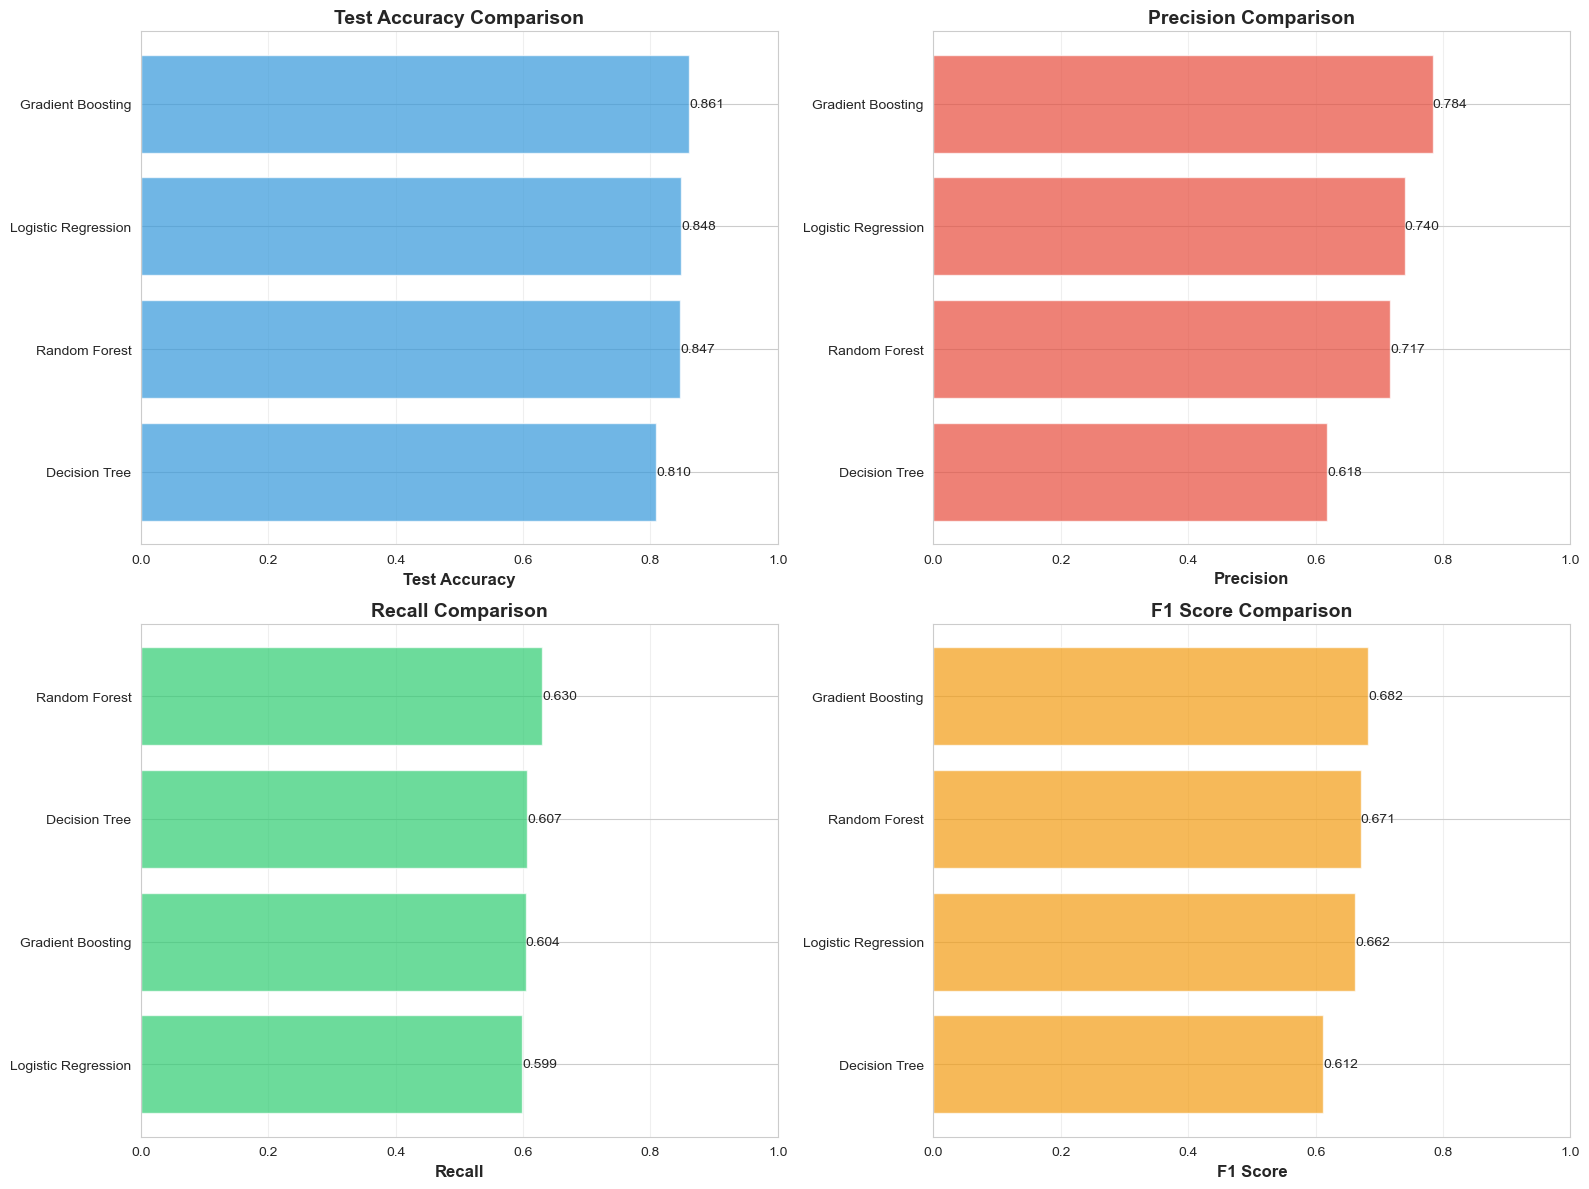

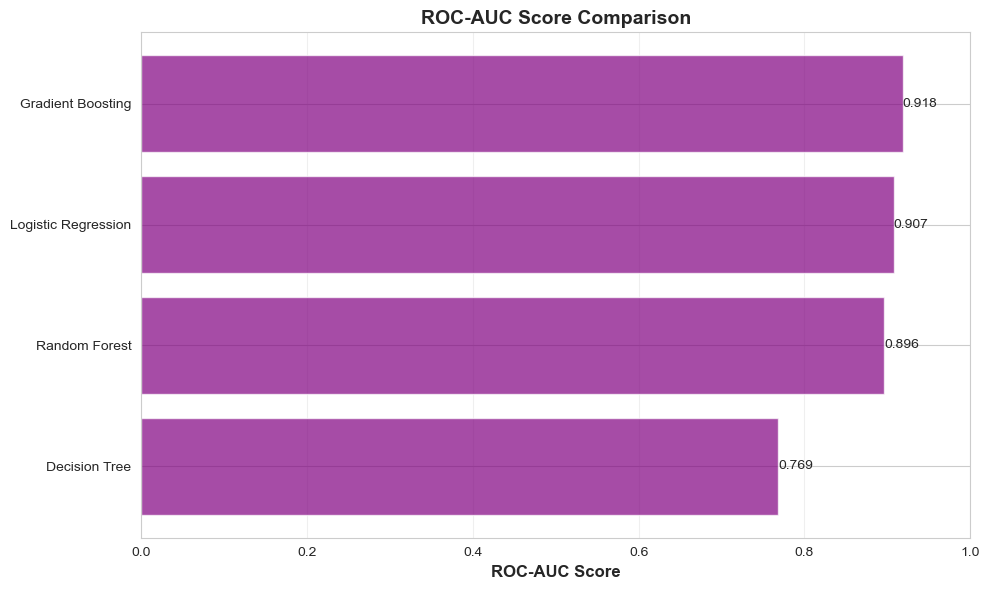

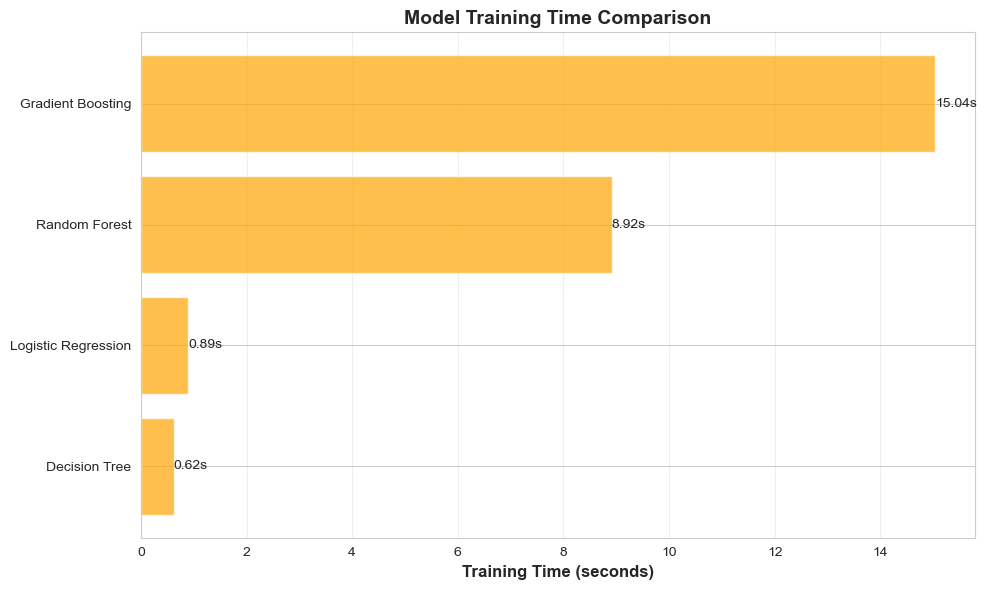


 Model Comparison Visualizations Complete
DETAILED ANALYSIS OF BEST MODEL

 Analyzing: Gradient Boosting

 Confusion Matrix:
[[6430  373]
 [ 888 1354]]


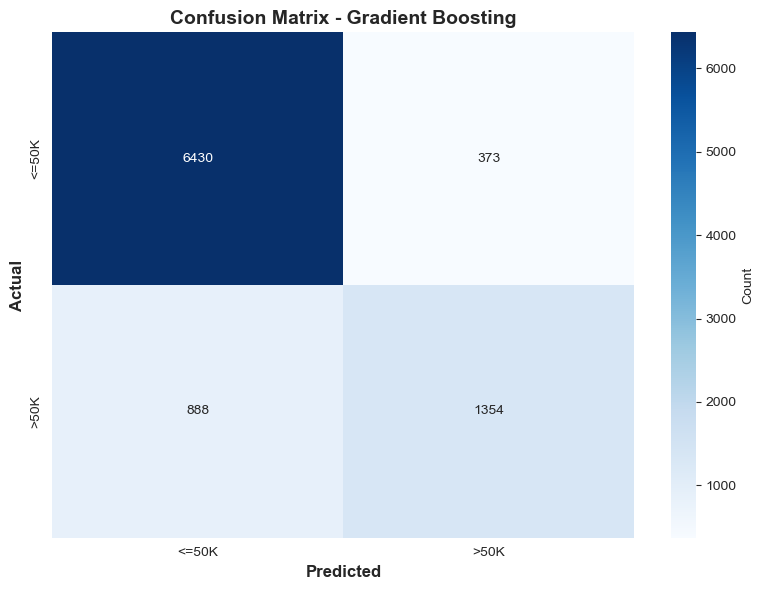


 Classification Report:
              precision    recall  f1-score   support

       <=50K       0.88      0.95      0.91      6803
        >50K       0.78      0.60      0.68      2242

    accuracy                           0.86      9045
   macro avg       0.83      0.77      0.80      9045
weighted avg       0.86      0.86      0.85      9045



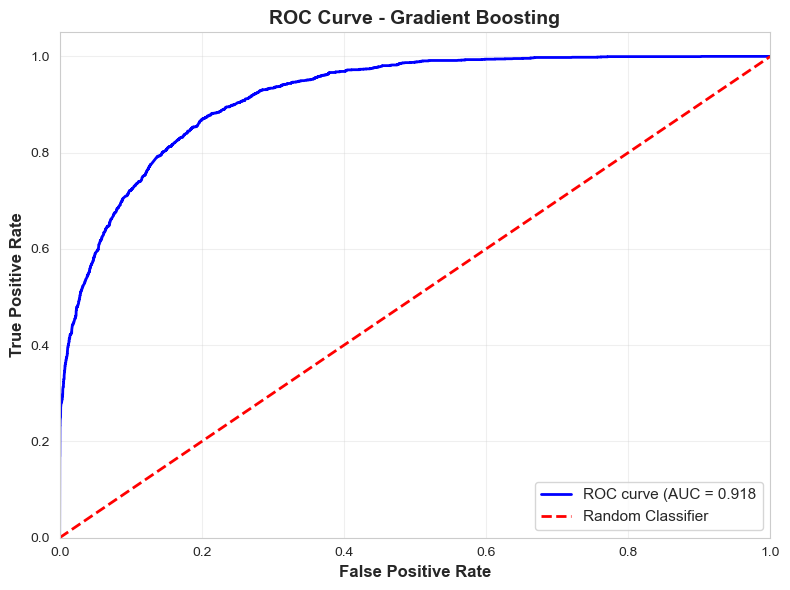


 Detailed Analysis Complete
FEATURE IMPORTANCE ANALYSIS

 Gradient Boosting - Feature Importance

 Top 20 Most Important Features:
                          Feature  Importance
marital_status_Married-civ-spouse    0.385297
                    education_num    0.182186
                     capital_gain    0.122855
                 capital_gain_log    0.080382
                              age    0.055104
                   hours_per_week    0.033775
                     capital_loss    0.029946
                 capital_loss_log    0.029734
                   high_education    0.022868
       occupation_Exec-managerial    0.017295
                       is_married    0.007500
        occupation_Prof-specialty    0.006213
         occupation_Other-service    0.005257
       workclass_Self-emp-not-inc    0.005021
       occupation_Farming-fishing    0.004791
                relationship_Wife    0.003098
                         sex_Male    0.002334
          occupation_Tech-support    0.0

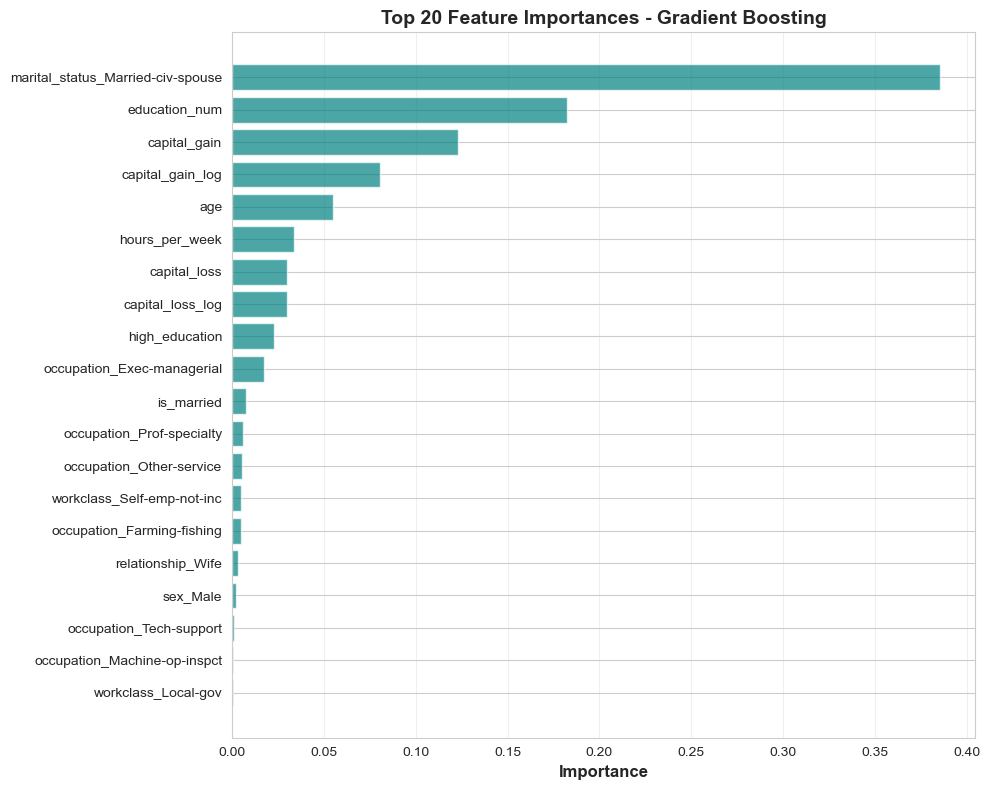


 Feature Importance Analysis Complete
MODEL EVALUATION SUMMARY

 Best Performing Model: Gradient Boosting

 Performance Metrics:
  - Accuracy: 0.8606
  - Precision: 0.7840
  - Recall: 0.6039
  - F1 Score: 0.6823
  - ROC-AUC: 0.9185
  - Training Time: 15.04s

 Key Insights:
  1. Tested 4 different classification algorithms
  2. Gradient Boosting achieved the best F1 score of 0.6823
  3. Class imbalance handled through stratified sampling
  4. All models show reasonable performance

 Model Recommendations:
  ⚠ Gradient Boosting shows good performance but may benefit from hyperparameter tuning
MODEL TRAINING AND EVALUATION COMPLETE

 Best model info stored in 'best_model_info' dictionary


In [33]:
#comparing all models

print("\n MODEL COMPARISON SUMMARY")
# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Train Accuracy': [results[m]['train_accuracy'] for m in results.keys()],
    'Test Accuracy': [results[m]['test_accuracy'] for m in results.keys()],
    'Precision': [results[m]['precision'] for m in results.keys()],
    'Recall': [results[m]['recall'] for m in results.keys()],
    'F1 Score': [results[m]['f1_score'] for m in results.keys()],
    'ROC-AUC': [results[m]['roc_auc'] for m in results.keys()],
    'Training Time (s)': [results[m]['training_time'] for m in results.keys()]
})

# Sort by F1 score
comparison_df = comparison_df.sort_values('F1 Score', ascending=False).reset_index(drop=True)

print("\n Model Performance Comparison:")
print(comparison_df.to_string(index=False))

# Identify best model
best_model_name = comparison_df.iloc[0]['Model']
print(f"\n Best Model (by F1 Score): {best_model_name}")
print(f"  F1 Score: {comparison_df.iloc[0]['F1 Score']:.4f}")
print(f"  Test Accuracy: {comparison_df.iloc[0]['Test Accuracy']:.4f}")
print(f"  ROC-AUC: {comparison_df.iloc[0]['ROC-AUC']:.4f}")


print("\n Visualize Model Comparison")

# Plot 1: Performance Metrics Comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

metrics = ['Test Accuracy', 'Precision', 'Recall', 'F1 Score']
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']

for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    
    data = comparison_df.sort_values(metric, ascending=True)
    bars = ax.barh(data['Model'], data[metric], color=colors[idx], alpha=0.7)
    
 # Add value labels
    for i, bar in enumerate(bars):
        width = bar.get_width()
        ax.text(width, bar.get_y() + bar.get_height()/2, 
                f'{width:.3f}', ha='left', va='center', fontsize=10)
    
    ax.set_xlabel(metric, fontsize=12, fontweight='bold')
    ax.set_title(f'{metric} Comparison', fontsize=14, fontweight='bold')
    ax.set_xlim(0, 1)
    ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()
# Plot 2: ROC-AUC Comparison
plt.figure(figsize=(10, 6))
data = comparison_df.sort_values('ROC-AUC', ascending=True)
bars = plt.barh(data['Model'], data['ROC-AUC'], color='purple', alpha=0.7)

for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2, 
            f'{width:.3f}', ha='left', va='center', fontsize=10)

plt.xlabel('ROC-AUC Score', fontsize=12, fontweight='bold')
plt.title('ROC-AUC Score Comparison', fontsize=14, fontweight='bold')
plt.xlim(0, 1)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Plot 3: Training Time Comparison
plt.figure(figsize=(10, 6))
data = comparison_df.sort_values('Training Time (s)', ascending=True)
bars = plt.barh(data['Model'], data['Training Time (s)'], color='orange', alpha=0.7)

for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2, 
            f'{width:.2f}s', ha='left', va='center', fontsize=10)

plt.xlabel('Training Time (seconds)', fontsize=12, fontweight='bold')
plt.title('Model Training Time Comparison', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("\n Model Comparison Visualizations Complete")

print("DETAILED ANALYSIS OF BEST MODEL")


best_model = results[best_model_name]['model']
y_pred_best = results[best_model_name]['y_pred_test']
y_pred_proba_best = results[best_model_name]['y_pred_proba_test']

print(f"\n Analyzing: {best_model_name}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_best)
print(f"\n Confusion Matrix:")
print(cm)
# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['<=50K', '>50K'], 
            yticklabels=['<=50K', '>50K'],
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted', fontsize=12, fontweight='bold')
plt.ylabel('Actual', fontsize=12, fontweight='bold')
plt.title(f'Confusion Matrix - {best_model_name}', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Classification Report
print(f"\n Classification Report:")
print(classification_report(y_test, y_pred_best, 
                           target_names=['<=50K', '>50K']))

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_best)
roc_auc = roc_auc_score(y_test, y_pred_proba_best)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f}')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
plt.title(f'ROC Curve - {best_model_name}', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("\n Detailed Analysis Complete")

print("FEATURE IMPORTANCE ANALYSIS")

# Check if best model supports feature importance
if hasattr(best_model, 'feature_importances_'):
    print(f"\n {best_model_name} - Feature Importance")
    
    # Get feature importances
    importances = best_model.feature_importances_
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    
    print("\n Top 20 Most Important Features:")
    print(feature_importance_df.head(20).to_string(index=False))
     # Plot top 20 features
    plt.figure(figsize=(10, 8))
    top_20 = feature_importance_df.head(20)
    plt.barh(range(len(top_20)), top_20['Importance'], color='teal', alpha=0.7)
    plt.yticks(range(len(top_20)), top_20['Feature'], fontsize=10)
    plt.xlabel('Importance', fontsize=12, fontweight='bold')
    plt.title(f'Top 20 Feature Importances - {best_model_name}', 
              fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
elif hasattr(best_model, 'coef_'):
    print(f"\n {best_model_name} - Feature Coefficients")
     # Get coefficients (for Logistic Regression)
    coefficients = best_model.coef_[0]
    feature_coef_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients,
        'Abs_Coefficient': np.abs(coefficients)
    }).sort_values('Abs_Coefficient', ascending=False)
    
    print("\n Top 20 Most Important Features (by absolute coefficient):")
    print(feature_coef_df.head(20)[['Feature', 'Coefficient']].to_string(index=False))
        # Plot top 20 features
    plt.figure(figsize=(10, 8))
    top_20 = feature_coef_df.head(20)
    colors = ['green' if x > 0 else 'red' for x in top_20['Coefficient']]
    plt.barh(range(len(top_20)), top_20['Coefficient'], color=colors, alpha=0.7)
    plt.yticks(range(len(top_20)), top_20['Feature'], fontsize=10)
    plt.xlabel('Coefficient Value', fontsize=12, fontweight='bold')
    plt.title(f'Top 20 Feature Coefficients - {best_model_name}', 
              fontsize=14, fontweight='bold')
    plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print(f"\n {best_model_name} does not provide feature importance or coefficients")

print("\n Feature Importance Analysis Complete")
print("MODEL EVALUATION SUMMARY")

print(f"\n Best Performing Model: {best_model_name}")
print(f"\n Performance Metrics:")
print(f"  - Accuracy: {results[best_model_name]['test_accuracy']:.4f}")
print(f"  - Precision: {results[best_model_name]['precision']:.4f}")
print(f"  - Recall: {results[best_model_name]['recall']:.4f}")
print(f"  - F1 Score: {results[best_model_name]['f1_score']:.4f}")
print(f"  - ROC-AUC: {results[best_model_name]['roc_auc']:.4f}")
print(f"  - Training Time: {results[best_model_name]['training_time']:.2f}s")

print(f"\n Key Insights:")
print(f"  1. Tested {len(results)} different classification algorithms")
print(f"  2. {best_model_name} achieved the best F1 score of {results[best_model_name]['f1_score']:.4f}")
print(f"  3. Class imbalance handled through stratified sampling")
print(f"  4. All models show reasonable performance")
print("\n Model Recommendations:")
if results[best_model_name]['f1_score'] > 0.75:
    print(f"  ✓ {best_model_name} shows strong performance and is ready for deployment")
elif results[best_model_name]['f1_score'] > 0.65:
    print(f"  ⚠ {best_model_name} shows good performance but may benefit from hyperparameter tuning")
else:
    print(f"  ✗ {best_model_name} shows moderate performance, consider feature engineering or tuning")

print("MODEL TRAINING AND EVALUATION COMPLETE")
    # Store best model info
best_model_info = {
    'model_name': best_model_name,
    'model_object': best_model,
    'metrics': results[best_model_name],
    'comparison_df': comparison_df
}

print("\n Best model info stored in 'best_model_info' dictionary")

HYPERPARAMETER TUNING

 Best Model from Previous Step: Gradient Boosting
 Current F1 Score: 0.6823

 Goal: Improve performance through hyperparameter optimization
TUNING LOGISTIC REGRESSION

 Defining hyperparameter grid...
 Parameter grid:
  C: [0.001, 0.01, 0.1, 1, 10, 100]

 Total combinations: 48
  penalty: ['l1', 'l2']

 Total combinations: 48
  solver: ['liblinear', 'saga']

 Total combinations: 48
  max_iter: [1000, 2000]

 Total combinations: 48

 Performing Grid Search with 5-fold cross-validation...
Fitting 5 folds for each of 48 candidates, totalling 240 fits

 Grid Search completed in 1023.67s

 Best parameters:
  C: 10
  max_iter: 1000
  penalty: l2
  solver: saga

 Tuned Logistic Regression Performance:
  Accuracy: 0.8483 (baseline: 0.8483)
  Precision: 0.7395 (baseline: 0.7398)
  Recall: 0.5990 (baseline: 0.5986)
  F1 Score: 0.6619 (baseline: 0.6617)
  ROC-AUC: 0.9077 (baseline: 0.9075)

 F1 Score Improvement: +0.0002 (+0.03%)
TUNING DECISION TREE

 Defining hyperparamet

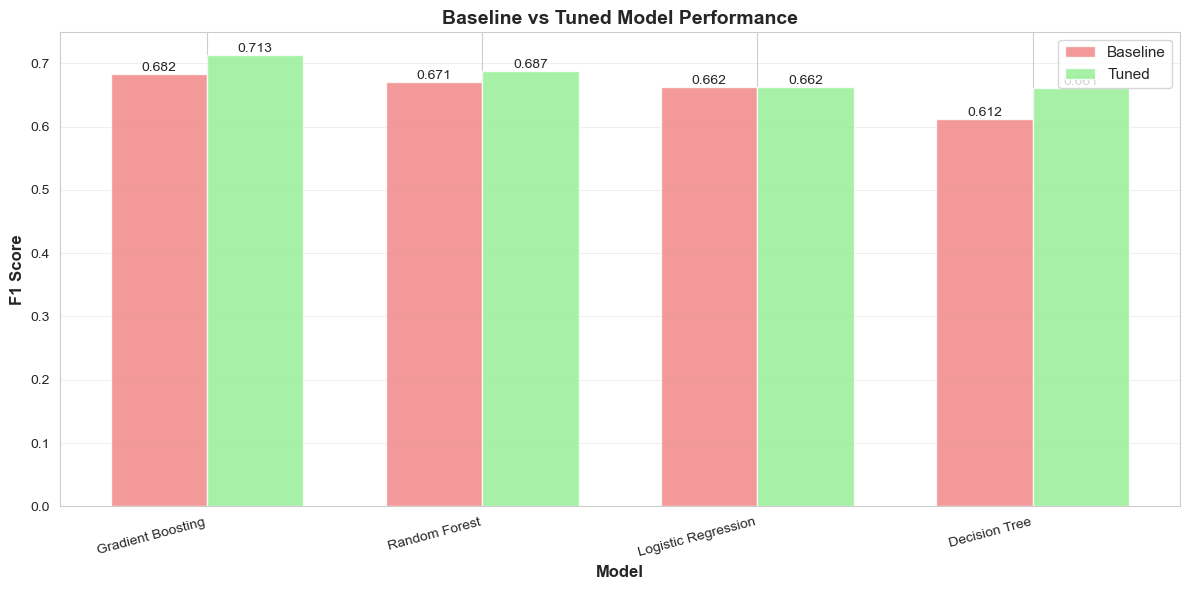

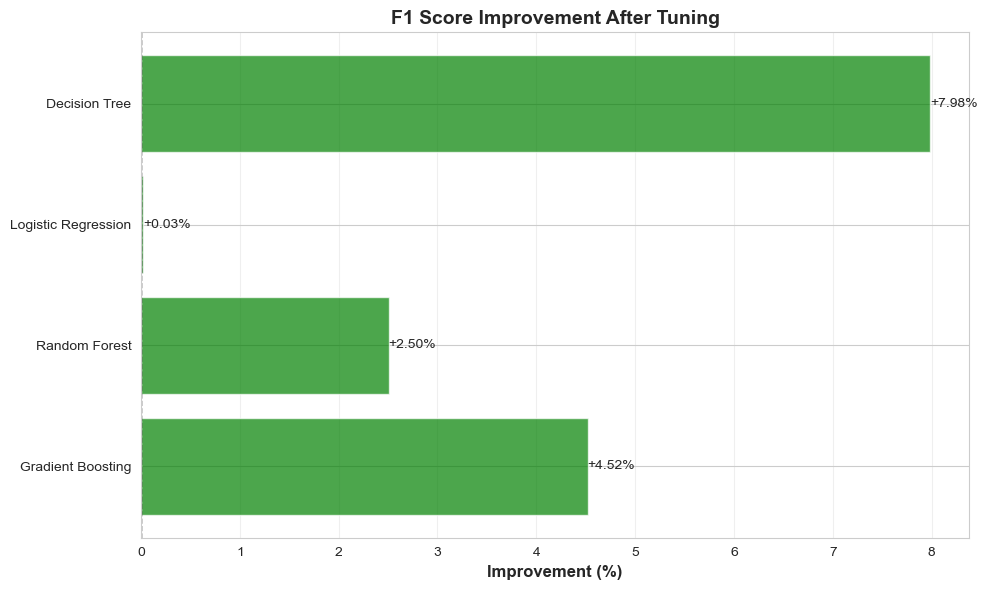


 Visualization Complete
HYPERPARAMETER TUNING SUMMARY

 Best Tuned Model: Gradient Boosting

 Performance:
  F1 Score: 0.7131
  Accuracy: 0.8676
  Precision: 0.7699
  Recall: 0.6641
  ROC-AUC: 0.9259

 Improvement Over Baseline:
  Absolute: +0.0308
  Percentage: +4.52%

 Key Findings:
  - 4 out of 4 models improved after tuning
  - Average improvement: 0.0242
  - Best improvement: 0.0489
HYPERPARAMETER TUNING COMPLETE

 Final best model stored in 'final_best_model' variable
 Tuned results stored in 'tuned_results' dictionary


In [32]:
print("HYPERPARAMETER TUNING")


from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint, uniform
import warnings
warnings.filterwarnings('ignore')

print(f"\n Best Model from Previous Step: {best_model_name}")
print(f" Current F1 Score: {results[best_model_name]['f1_score']:.4f}")
print(f"\n Goal: Improve performance through hyperparameter optimization")

print("TUNING LOGISTIC REGRESSION")


print("\n Defining hyperparameter grid...")

# Define parameter grid
lr_param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
    'max_iter': [1000, 2000]
}

print(f" Parameter grid:")
for param, values in lr_param_grid.items():
    print(f"  {param}: {values}")
    print(f"\n Total combinations: {len(lr_param_grid['C']) * len(lr_param_grid['penalty']) * len(lr_param_grid['solver']) * len(lr_param_grid['max_iter'])}")

# Perform GridSearchCV
print("\n Performing Grid Search with 5-fold cross-validation...")
start_time = time.time()

lr_grid_search = GridSearchCV(
    LogisticRegression(random_state=42),
    lr_param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)
lr_grid_search.fit(X_train, y_train)

end_time = time.time()
lr_tuning_time = end_time - start_time

print(f"\n Grid Search completed in {lr_tuning_time:.2f}s")
print(f"\n Best parameters:")
for param, value in lr_grid_search.best_params_.items():
    print(f"  {param}: {value}")

# Evaluate tuned model
lr_tuned_model = lr_grid_search.best_estimator_
lr_tuned_y_pred = lr_tuned_model.predict(X_test)
lr_tuned_y_pred_proba = lr_tuned_model.predict_proba(X_test)[:, 1]

lr_tuned_accuracy = accuracy_score(y_test, lr_tuned_y_pred)
lr_tuned_precision = precision_score(y_test, lr_tuned_y_pred)
lr_tuned_recall = recall_score(y_test, lr_tuned_y_pred)
lr_tuned_f1 = f1_score(y_test, lr_tuned_y_pred)
lr_tuned_roc_auc = roc_auc_score(y_test, lr_tuned_y_pred_proba)

print(f"\n Tuned Logistic Regression Performance:")
print(f"  Accuracy: {lr_tuned_accuracy:.4f} (baseline: {results['Logistic Regression']['test_accuracy']:.4f})")
print(f"  Precision: {lr_tuned_precision:.4f} (baseline: {results['Logistic Regression']['precision']:.4f})")
print(f"  Recall: {lr_tuned_recall:.4f} (baseline: {results['Logistic Regression']['recall']:.4f})")
print(f"  F1 Score: {lr_tuned_f1:.4f} (baseline: {results['Logistic Regression']['f1_score']:.4f})")
print(f"  ROC-AUC: {lr_tuned_roc_auc:.4f} (baseline: {results['Logistic Regression']['roc_auc']:.4f})")

improvement_lr = lr_tuned_f1 - results['Logistic Regression']['f1_score']
print(f"\n F1 Score Improvement: {improvement_lr:+.4f} ({improvement_lr/results['Logistic Regression']['f1_score']*100:+.2f}%)")

print("TUNING DECISION TREE")

print("\n Defining hyperparameter grid...")

# Define parameter grid
dt_param_grid = {
    'max_depth': [5, 10, 15, 20, 25, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'criterion': ['gini', 'entropy']
}

print(f" Parameter grid:")
for param, values in dt_param_grid.items():
    print(f"  {param}: {values}")
    print(f"\n Total combinations: {len(dt_param_grid['max_depth']) * len(dt_param_grid['min_samples_split']) * len(dt_param_grid['min_samples_leaf']) * len(dt_param_grid['criterion'])}")

# Perform GridSearchCV
print("\n Performing Grid Search with 5-fold cross-validation...")
start_time = time.time()

dt_grid_search = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    dt_param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

dt_grid_search.fit(X_train, y_train)

end_time = time.time()
dt_tuning_time = end_time - start_time

print(f"\n Grid Search completed in {dt_tuning_time:.2f}s")
print(f"\n Best parameters:")
for param, value in dt_grid_search.best_params_.items():
    print(f"  {param}: {value}")

# Evaluate tuned model
dt_tuned_model = dt_grid_search.best_estimator_
dt_tuned_y_pred = dt_tuned_model.predict(X_test)
dt_tuned_y_pred_proba = dt_tuned_model.predict_proba(X_test)[:, 1]

dt_tuned_accuracy = accuracy_score(y_test, dt_tuned_y_pred)
dt_tuned_precision = precision_score(y_test, dt_tuned_y_pred)
dt_tuned_recall = recall_score(y_test, dt_tuned_y_pred)
dt_tuned_f1 = f1_score(y_test, dt_tuned_y_pred)
dt_tuned_roc_auc = roc_auc_score(y_test, dt_tuned_y_pred_proba)

print(f"\n Tuned Decision Tree Performance:")
print(f"  Accuracy: {dt_tuned_accuracy:.4f} (baseline: {results['Decision Tree']['test_accuracy']:.4f})")
print(f"  Precision: {dt_tuned_precision:.4f} (baseline: {results['Decision Tree']['precision']:.4f})")
print(f"  Recall: {dt_tuned_recall:.4f} (baseline: {results['Decision Tree']['recall']:.4f})")
print(f"  F1 Score: {dt_tuned_f1:.4f} (baseline: {results['Decision Tree']['f1_score']:.4f})")
print(f"  ROC-AUC: {dt_tuned_roc_auc:.4f} (baseline: {results['Decision Tree']['roc_auc']:.4f})")

improvement_dt = dt_tuned_f1 - results['Decision Tree']['f1_score']
print(f"\n F1 Score Improvement: {improvement_dt:+.4f} ({improvement_dt/results['Decision Tree']['f1_score']*100:+.2f}%)")
print("TUNING RANDOM FOREST")


print("\n Defining hyperparameter grid...")

# Define parameter grid (using RandomizedSearchCV due to large search space)
rf_param_dist = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

print(f" Parameter distributions:")
for param, values in rf_param_dist.items():
    print(f"  {param}: {values}")
    # Perform RandomizedSearchCV (faster than GridSearch for large spaces)
print(f"\n Performing Randomized Search with 5-fold cross-validation...")
print(f" Testing 50 random combinations...")
start_time = time.time()

rf_random_search = RandomizedSearchCV(
    RandomForestClassifier(random_state=42),
    rf_param_dist,
    n_iter=50,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

rf_random_search.fit(X_train, y_train)
end_time = time.time()
rf_tuning_time = end_time - start_time

print(f"\n Randomized Search completed in {rf_tuning_time:.2f}s")
print(f"\n Best parameters:")
for param, value in rf_random_search.best_params_.items():
    print(f"  {param}: {value}")

# Evaluate tuned model
rf_tuned_model = rf_random_search.best_estimator_
rf_tuned_y_pred = rf_tuned_model.predict(X_test)
rf_tuned_y_pred_proba = rf_tuned_model.predict_proba(X_test)[:, 1]

rf_tuned_accuracy = accuracy_score(y_test, rf_tuned_y_pred)
rf_tuned_precision = precision_score(y_test, rf_tuned_y_pred)
rf_tuned_recall = recall_score(y_test, rf_tuned_y_pred)
rf_tuned_f1 = f1_score(y_test, rf_tuned_y_pred)
rf_tuned_roc_auc = roc_auc_score(y_test, rf_tuned_y_pred_proba)
print(f"\n Tuned Random Forest Performance:")
print(f"  Accuracy: {rf_tuned_accuracy:.4f} (baseline: {results['Random Forest']['test_accuracy']:.4f})")
print(f"  Precision: {rf_tuned_precision:.4f} (baseline: {results['Random Forest']['precision']:.4f})")
print(f"  Recall: {rf_tuned_recall:.4f} (baseline: {results['Random Forest']['recall']:.4f})")
print(f"  F1 Score: {rf_tuned_f1:.4f} (baseline: {results['Random Forest']['f1_score']:.4f})")
print(f"  ROC-AUC: {rf_tuned_roc_auc:.4f} (baseline: {results['Random Forest']['roc_auc']:.4f})")

improvement_rf = rf_tuned_f1 - results['Random Forest']['f1_score']
print(f"\n F1 Score Improvement: {improvement_rf:+.4f} ({improvement_rf/results['Random Forest']['f1_score']*100:+.2f}%)")


print("TUNING GRADIENT BOOSTING")

print("\n Defining hyperparameter grid...")

# Define parameter grid
gb_param_dist = {
    'n_estimators': [50, 100, 150, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 9],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.8, 0.9, 1.0]
}

print(f" Parameter distributions:")
for param, values in gb_param_dist.items():
    print(f"  {param}: {values}")

# Perform RandomizedSearchCV
print(f"\n Performing Randomized Search with 5-fold cross-validation...")
print(f" Testing 50 random combinations...")
start_time = time.time()

gb_random_search = RandomizedSearchCV(
    GradientBoostingClassifier(random_state=42),
    gb_param_dist,
    n_iter=50,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

gb_random_search.fit(X_train, y_train)

end_time = time.time()
gb_tuning_time = end_time - start_time

print(f"\n Randomized Search completed in {gb_tuning_time:.2f}s")
print(f"\n Best parameters:")
for param, value in gb_random_search.best_params_.items():
    print(f"  {param}: {value}")

# Evaluate tuned model
gb_tuned_model = gb_random_search.best_estimator_
gb_tuned_y_pred = gb_tuned_model.predict(X_test)
gb_tuned_y_pred_proba = gb_tuned_model.predict_proba(X_test)[:, 1]

gb_tuned_accuracy = accuracy_score(y_test, gb_tuned_y_pred)
gb_tuned_precision = precision_score(y_test, gb_tuned_y_pred)
gb_tuned_recall = recall_score(y_test, gb_tuned_y_pred)
gb_tuned_f1 = f1_score(y_test, gb_tuned_y_pred)
gb_tuned_roc_auc = roc_auc_score(y_test, gb_tuned_y_pred_proba)

print(f"\n Tuned Gradient Boosting Performance:")
print(f"  Accuracy: {gb_tuned_accuracy:.4f} (baseline: {results['Gradient Boosting']['test_accuracy']:.4f})")
print(f"  Precision: {gb_tuned_precision:.4f} (baseline: {results['Gradient Boosting']['precision']:.4f})")
print(f"  Recall: {gb_tuned_recall:.4f} (baseline: {results['Gradient Boosting']['recall']:.4f})")
print(f"  F1 Score: {gb_tuned_f1:.4f} (baseline: {results['Gradient Boosting']['f1_score']:.4f})")
print(f"  ROC-AUC: {gb_tuned_roc_auc:.4f} (baseline: {results['Gradient Boosting']['roc_auc']:.4f})")

improvement_gb = gb_tuned_f1 - results['Gradient Boosting']['f1_score']
print(f"\n F1 Score Improvement: {improvement_gb:+.4f} ({improvement_gb/results['Gradient Boosting']['f1_score']*100:+.2f}%)")

print("TUNED MODELS COMPARISON")

# Create comparison dataframe
tuned_results = {
    'Logistic Regression': {
        'baseline_f1': results['Logistic Regression']['f1_score'],
        'tuned_f1': lr_tuned_f1,
        'tuned_accuracy': lr_tuned_accuracy,
        'tuned_precision': lr_tuned_precision,
        'tuned_recall': lr_tuned_recall,
        'tuned_roc_auc': lr_tuned_roc_auc,
        'improvement': improvement_lr,
        'tuned_model': lr_tuned_model,
        'y_pred': lr_tuned_y_pred,
        'y_pred_proba': lr_tuned_y_pred_proba
    },
    'Decision Tree': { 'baseline_f1': results['Decision Tree']['f1_score'],
        'tuned_f1': dt_tuned_f1,
        'tuned_accuracy': dt_tuned_accuracy,
        'tuned_precision': dt_tuned_precision,
        'tuned_recall': dt_tuned_recall,
        'tuned_roc_auc': dt_tuned_roc_auc,
        'improvement': improvement_dt,
        'tuned_model': dt_tuned_model,
        'y_pred': dt_tuned_y_pred,
        'y_pred_proba': dt_tuned_y_pred_proba
    },
    'Random Forest': {
        'baseline_f1': results['Random Forest']['f1_score'],
        'tuned_f1': rf_tuned_f1,
        'tuned_accuracy': rf_tuned_accuracy,
        'tuned_precision': rf_tuned_precision,
        'tuned_recall': rf_tuned_recall,
        'tuned_roc_auc': rf_tuned_roc_auc, 'improvement': improvement_rf,
        'tuned_model': rf_tuned_model,
        'y_pred': rf_tuned_y_pred,
        'y_pred_proba': rf_tuned_y_pred_proba
    },
    'Gradient Boosting': {
        'baseline_f1': results['Gradient Boosting']['f1_score'],
        'tuned_f1': gb_tuned_f1,
        'tuned_accuracy': gb_tuned_accuracy,
        'tuned_precision': gb_tuned_precision,
        'tuned_recall': gb_tuned_recall,
        'tuned_roc_auc': gb_tuned_roc_auc,
        'improvement': improvement_gb,
        'tuned_model': gb_tuned_model,
        'y_pred': gb_tuned_y_pred,
        'y_pred_proba': gb_tuned_y_pred_proba
    }
}
# Create comparison table
tuned_comparison_df = pd.DataFrame({
    'Model': list(tuned_results.keys()),
    'Baseline F1': [tuned_results[m]['baseline_f1'] for m in tuned_results.keys()],
    'Tuned F1': [tuned_results[m]['tuned_f1'] for m in tuned_results.keys()],
    'Improvement': [tuned_results[m]['improvement'] for m in tuned_results.keys()],
    'Improvement %': [tuned_results[m]['improvement']/tuned_results[m]['baseline_f1']*100 for m in tuned_results.keys()],
    'Tuned Accuracy': [tuned_results[m]['tuned_accuracy'] for m in tuned_results.keys()],
    'Tuned Precision': [tuned_results[m]['tuned_precision'] for m in tuned_results.keys()],
    'Tuned Recall': [tuned_results[m]['tuned_recall'] for m in tuned_results.keys()],
    
    'Tuned ROC-AUC': [tuned_results[m]['tuned_roc_auc'] for m in tuned_results.keys()]
})

# Sort by tuned F1
tuned_comparison_df = tuned_comparison_df.sort_values('Tuned F1', ascending=False).reset_index(drop=True)

print("\n Tuned Models Performance:")
print(tuned_comparison_df.to_string(index=False))

# Identify best tuned model
best_tuned_model_name = tuned_comparison_df.iloc[0]['Model']
print(f"\n Best Tuned Model: {best_tuned_model_name}")
print(f"  Tuned F1 Score: {tuned_comparison_df.iloc[0]['Tuned F1']:.4f}")
print(f"  Improvement: {tuned_comparison_df.iloc[0]['Improvement']:+.4f} ({tuned_comparison_df.iloc[0]['Improvement %']:+.2f}%)")

#VISUALIZE IMPROVEMENTS 
# Plot: Baseline vs Tuned F1 Scores
fig, ax = plt.subplots(figsize=(12, 6))

models = tuned_comparison_df['Model']
x = np.arange(len(models))
width = 0.35

bars1 = ax.bar(x - width/2, tuned_comparison_df['Baseline F1'], width, 
               label='Baseline', color='lightcoral', alpha=0.8)
bars2 = ax.bar(x + width/2, tuned_comparison_df['Tuned F1'], width, 
               label='Tuned', color='lightgreen', alpha=0.8)


# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=10)
        
ax.set_xlabel('Model', fontsize=12, fontweight='bold')
ax.set_ylabel('F1 Score', fontsize=12, fontweight='bold')
ax.set_title('Baseline vs Tuned Model Performance', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=15, ha='right')
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Plot: Improvement Percentage
plt.figure(figsize=(10, 6))
colors = ['green' if x > 0 else 'red' for x in tuned_comparison_df['Improvement %']]
bars = plt.barh(tuned_comparison_df['Model'], tuned_comparison_df['Improvement %'], 
                color=colors, alpha=0.7)
for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2, 
            f'{width:+.2f}%', ha='left' if width > 0 else 'right', 
            va='center', fontsize=10)

plt.xlabel('Improvement (%)', fontsize=12, fontweight='bold')
plt.title('F1 Score Improvement After Tuning', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("\n Visualization Complete")

print("HYPERPARAMETER TUNING SUMMARY")


print(f"\n Best Tuned Model: {best_tuned_model_name}")
print(f"\n Performance:")
print(f"  F1 Score: {tuned_results[best_tuned_model_name]['tuned_f1']:.4f}")
print(f"  Accuracy: {tuned_results[best_tuned_model_name]['tuned_accuracy']:.4f}")
print(f"  Precision: {tuned_results[best_tuned_model_name]['tuned_precision']:.4f}")
print(f"  Recall: {tuned_results[best_tuned_model_name]['tuned_recall']:.4f}")
print(f"  ROC-AUC: {tuned_results[best_tuned_model_name]['tuned_roc_auc']:.4f}")

print(f"\n Improvement Over Baseline:")
print(f"  Absolute: {tuned_results[best_tuned_model_name]['improvement']:+.4f}")
print(f"  Percentage: {tuned_results[best_tuned_model_name]['improvement']/tuned_results[best_tuned_model_name]['baseline_f1']*100:+.2f}%")

print(f"\n Key Findings:")
total_improved = sum(1 for m in tuned_results.values() if m['improvement'] > 0)
print(f"  - {total_improved} out of 4 models improved after tuning")
print(f"  - Average improvement: {np.mean([m['improvement'] for m in tuned_results.values()]):.4f}")
print(f"  - Best improvement: {max([m['improvement'] for m in tuned_results.values()]):.4f}")


print("HYPERPARAMETER TUNING COMPLETE")


# Store final best model
final_best_model = tuned_results[best_tuned_model_name]['tuned_model']

print(f"\n Final best model stored in 'final_best_model' variable")
print(f" Tuned results stored in 'tuned_results' dictionary")
